In [14]:
import json
import logging
from pathlib import Path
from copy import deepcopy

import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import pandas as pd
from typing import Dict, Any, List


In [2]:


# ---------------------------
# LOGGING & CONFIG
# ---------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [19]:


# CONFIGURATION
COCO_JSON        = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json")
IMAGES_DIR       = Path("../data/rotation/batches/rotation_20250721_01/images/default/")
PRED_JSON        = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_predicted.json")
COCO_5OBB       = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_updated.json")
CHECKPOINT_PATH = Path("checkpoints/best_model.pth")

BATCHES_DIR = Path("../data/rotation/batches/")

In [4]:

CLASS_NAMES = [0, 180, 270, 90 ]
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_SIZE = 300

TRANSFORM = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [5]:
# ---------------------------
# I/O
# ---------------------------
def load_coco(path: Path) -> dict:
    logger.info(f"Loading COCO from {path}")
    return json.loads(path.read_text(encoding="utf-8"))

def save_coco(coco: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    logger.info(f"Writing COCO to {path}")
    path.write_text(json.dumps(coco, ensure_ascii=False, indent=2), encoding="utf-8")

# ---------------------------
# MODEL
# ---------------------------
def load_model(ckpt_path: Path) -> nn.Module:
    logger.info(f"Loading model from {ckpt_path}")
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, len(CLASS_NAMES))
    ckpt = torch.load(str(ckpt_path), map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    return model.to(DEVICE).eval()

In [38]:
# ---------------------------
# HELPERS
# ---------------------------
def extract_current_rotation(ann: dict) -> float:
    bb = ann.get("bbox", [])
    if len(bb) == 5:
        return float(bb[4])
    attrs = ann.get("attributes", {})
    return float(attrs.get("rotation", 0.0))

def crop_box(img: np.ndarray, x, y, w, h) -> np.ndarray:
    x1, y1 = max(0, int(round(x))), max(0, int(round(y)))
    x2 = min(img.shape[1], int(round(x + w)))
    y2 = min(img.shape[0], int(round(y + h)))
    return img[y1:y2, x1:x2]

def crop_rotated_preserve(img: np.ndarray, cx, cy, w, h, angle: float) -> np.ndarray:
    # compute AABB of the rotated rectangle
    theta = np.deg2rad(angle)
    w2 = abs(w*np.cos(theta)) + abs(h*np.sin(theta))
    h2 = abs(w*np.sin(theta)) + abs(h*np.cos(theta))
    x1 = int(round(cx - w2/2))
    y1 = int(round(cy - h2/2))
    x2 = int(round(cx + w2/2))
    y2 = int(round(cy + h2/2))
    # clamp
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)
    return img[y1:y2, x1:x2], (x1, y1, x2, y2)

## Convert Coco to 5 Tuples 

In [15]:
def create_obb_tuple(anns: Dict[str, Any]) -> None:
    """
    Convert axis-aligned bbox [x, y, w, h] to oriented bbox [cx, cy, w, h, angle].
    Added validation and debug logging in place of print statements.
    """
    bbox = anns.get("bbox")
    if isinstance(bbox, list) and len(bbox) == 4:
        x, y, w, h = bbox
        cx = x + w / 2
        cy = y + h / 2
        angle = anns.get("attributes", {}).get("rotation", 0.0)
        anns["bbox"] = [cx, cy, w, h, angle]
        logger.debug(f"Converted bbox to OBB: {anns['bbox']} for annotation id {anns.get('id')}")
    else:
        logger.warning(f"Unexpected bbox format for annotation id {anns.get('id')}: {bbox}")

In [21]:
def replace_obb(coco: Dict[str, Any], batch_dir: Path) -> None:
    """
    Apply create_obb_tuple to all annotations and write updated JSON efficiently.
    """
    logger.info("Replacing OBBs in annotations")
    for anns in coco.get('annotations', []):
        create_obb_tuple(anns)

    #out_path = batch_dir / "annotations" / "instances_updated.json"
    out_path = COCO_5OBB
    logger.info(f"Writing updated annotations to {out_path}")
    with open(out_path, 'w', encoding='utf-8') as f:
        # Use json.dump for more efficient writing
        json.dump(coco, f, ensure_ascii=False)


def convert_all_batches() -> None:
    """
    Iterate over all batch directories and update OBBs.
    """
    for p in BATCHES_DIR.iterdir():
        if "rotation" in p.name:
            json_path = p / "annotations" / "instances_default.json"
            if json_path.exists():
                logger.info(f"Processing batch: {p.name}")
                coco = load_coco(json_path)
                replace_obb(coco, p)
            else:
                logger.warning(f"Missing JSON at {json_path}")
                


In [22]:
convert_all_batches()


INFO:__main__:Processing batch: rotation_20250721_01
INFO:__main__:Loading COCO from ../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json
INFO:__main__:Replacing OBBs in annotations
INFO:__main__:Writing updated annotations to ../data/rotation/batches/rotation_20250721_01/annotations/instances_updated.json


In [37]:
def predict_angle(model: nn.Module, patch: np.ndarray) -> float:
    rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    tensor = TRANSFORM(pil).unsqueeze(0).to(DEVICE)
    print(f"Tensor {tensor}")
    with torch.no_grad():
        prediction = model(tensor)
        print(f"logits {prediction}")

        idx = torch.argmax(prediction, dim=1).item()
        print(f"idx {idx}")

    return float(CLASS_NAMES[idx])

In [39]:
def debug_annotation(ann_id, img_id, fname, orig_rot, pred_rot, bbox, full_img, patch, aabb_coords=None):
    cx, cy, w, h, angle = bbox
    
    # choose crop that preserves full object
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    full_rgb  = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)

    print(f"\n▶ Ann {ann_id} on img {img_id} ({fname})")
    print(f"  orig_rot: {orig_rot}°, pred_rot: {pred_rot}°")
    print(f"  bbox: {bbox}")
    
    x = cx - (w/2)
    y = cy - (h/2)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), dpi=150)
    ax1.imshow(patch_rgb); ax1.axis("off")
    ax1.set_title(f"Rotated crop ({patch.shape[1]}×{patch.shape[0]})")
    ax2.imshow(full_rgb); ax2.axis("off")
    # overlay both:
    ax2.add_patch(Rectangle((cx, cy), w, h,     # TODO: hier muss man eventuell zu x,y zuruck rechnen
                            edgecolor="orange", linestyle="--", fill=False))
    obb = Rectangle((cx-w/2, cy-h/2), w, h,
                    edgecolor="red", fill=False)
    # draw rotated CW by orig_rot → rotate CCW by -orig_rot
    obb.set_transform(Affine2D().rotate_deg_around(cx, cy, -orig_rot) + ax2.transData)
    ax2.add_patch(obb)
    ax2.scatter([x],[y], color="blue", s=5)
    ax2.scatter([cx],[cy], color="lime", s=5)
    ax2.set_title("Full image w/ OBB")
    
    ##print the boxes used for training
        # Pinke Box für AABB von crop_rotated_preserve
    x1, y1, x2, y2 = aabb_coords
        
    aabb = Rectangle((x1, y1), x2 - x1, y2 - y1,
                     edgecolor="deeppink", linestyle=":", linewidth=1.5, fill=False)
    ax2.add_patch(aabb)
    
    
    plt.show()


INFO:__main__:Loading COCO from ../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json
INFO:__main__:Loading COCO from ../data/rotation/batches/rotation_20250721_01/annotations/instances_updated.json
INFO:__main__:Loading model from checkpoints/best_model.pth


patch[[[250 250 250]
  [222 222 222]
  [218 218 218]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[191 191 191]
  [ 16  16  16]
  [  5   5   5]
  ...
  [253 253 253]
  [254 254 254]
  [255 255 255]]

 [[154 154 154]
  [  4   4   4]
  [  3   3   3]
  ...
  [168 168 168]
  [252 252 252]
  [254 254 254]]

 ...

 [[154 154 154]
  [  3   3   3]
  [  0   0   0]
  ...
  [ 93  93  93]
  [236 236 236]
  [254 254 254]]

 [[160 160 160]
  [  1   1   1]
  [  0   0   0]
  ...
  [236 236 236]
  [254 254 254]
  [255 255 255]]

 [[227 227 227]
  [108 108 108]
  [ 93  93  93]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.1633, 2.1633, 2.1633,  ..., 2.2489, 2.2489, 2.2489],
          [2.1633, 2.1633, 2.1633,  ..., 2.2489, 2.2489, 2.2489],
          [2.1633, 2.1633, 2.1633,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [1.7694, 1.7694, 1.7694,  ..., 2.2489, 2.2489, 2.2489],
          [1.7694, 1.7694, 1.7694,  ..., 2.2489, 2.2489, 2.2489],
          [1.

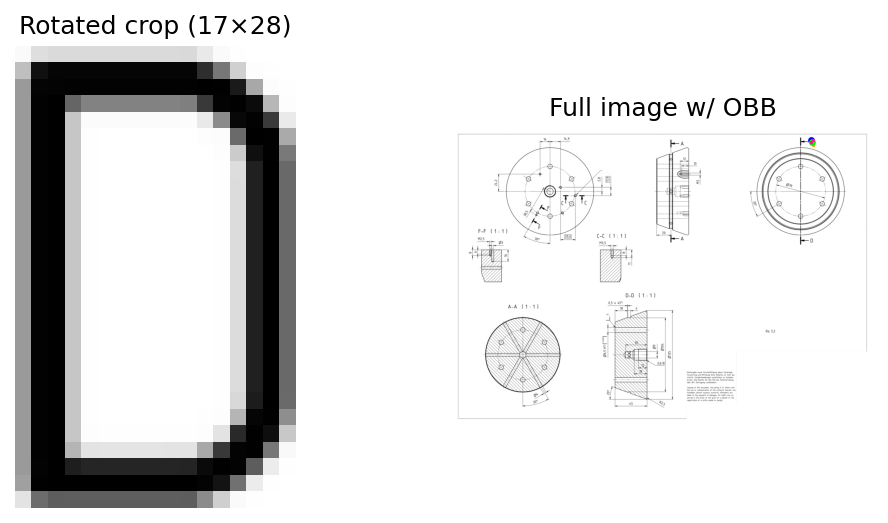

INFO:__main__:Ann 49: 0.11° → 0.0°


patch[[[254 254 254]
  [253 253 253]
  [253 253 253]
  ...
  [182 182 182]
  [238 238 238]
  [254 254 254]]

 [[255 255 255]
  [251 251 251]
  [175 175 175]
  ...
  [  6   6   6]
  [184 184 184]
  [252 252 252]]

 [[254 254 254]
  [144 144 144]
  [  9   9   9]
  ...
  [118 118 118]
  [224 224 224]
  [253 253 253]]

 ...

 [[253 253 253]
  [251 251 251]
  [252 252 252]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
          [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
          [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

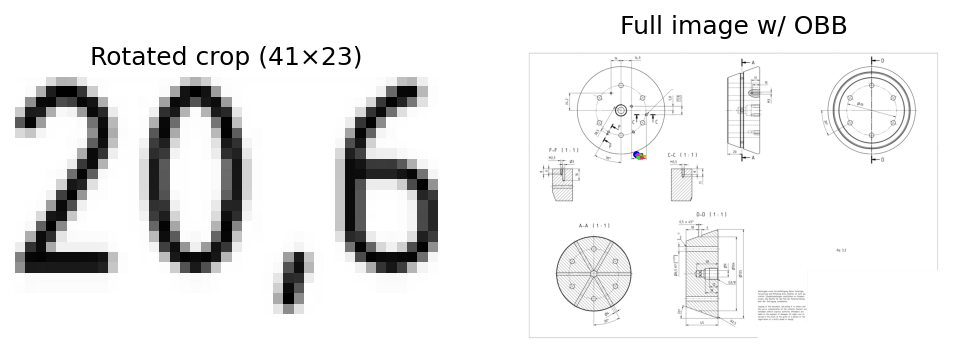

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [249 249 249]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [225 225 225]
  [253 253 253]
  [255 255 255]]

 ...

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [236 236 236]
  [253 253 253]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [252 252 252]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

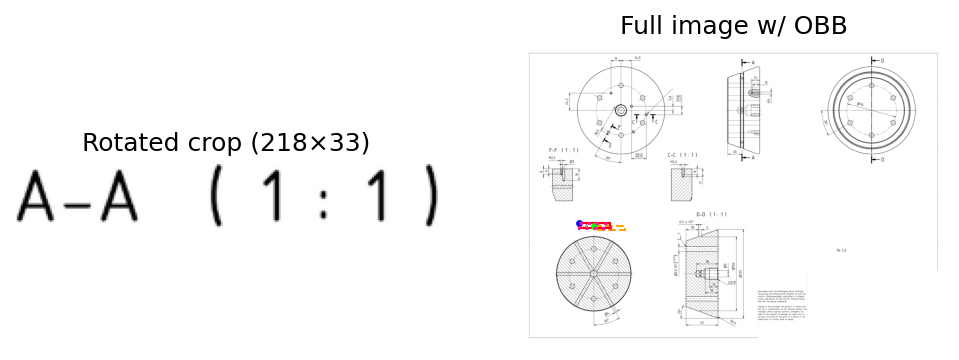

patch[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [243 243 243]
  [254 254 254]
  [254 254 254]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [ 90  90  90]
  [228 228 228]
  [254 254 254]]

 [[232 232 232]
  [135 135 135]
  [209 209 209]
  ...
  [  6   6   6]
  [ 78  78  78]
  [239 239 239]]

 ...

 [[254 254 254]
  [246 246 246]
  [105 105 105]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [246 246 246]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
          [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
          [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2318],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

INFO:__main__:Ann 51: 270.0° → 0.0°


logits tensor([[  4.9202, -21.3370,  -4.2885,   2.8190]])
idx 0

▶ Ann 51 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [394.65, 928.8000000000001, 19.0, 18.9, 270.0]


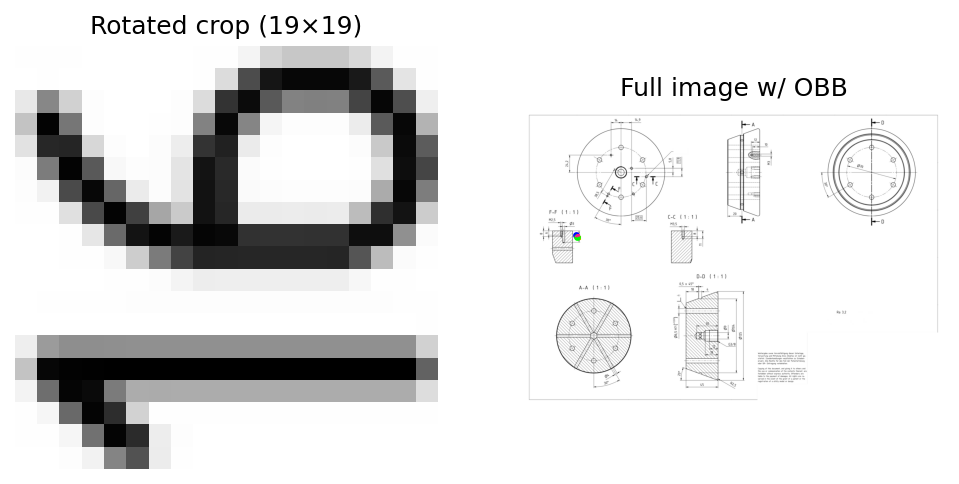

patch[[[255 255 255]
  [255 255 255]
  [252 252 252]
  [227 227 227]
  [176 176 176]
  [174 174 174]
  [202 202 202]
  [243 243 243]
  [254 254 254]
  [254 254 254]
  [236 236 236]
  [204 204 204]
  [173 173 173]
  [175 175 175]
  [173 173 173]
  [206 206 206]
  [246 246 246]
  [255 255 255]
  [255 255 255]]

 [[253 253 253]
  [251 251 251]
  [154 154 154]
  [ 35  35  35]
  [  8   8   8]
  [  7   7   7]
  [ 15  15  15]
  [ 84  84  84]
  [223 223 223]
  [182 182 182]
  [ 52  52  52]
  [ 15  15  15]
  [  7   7   7]
  [  7   7   7]
  [  7   7   7]
  [ 17  17  17]
  [ 98  98  98]
  [233 233 233]
  [253 253 253]]

 [[253 253 253]
  [144 144 144]
  [ 11  11  11]
  [ 23  23  23]
  [129 129 129]
  [151 151 151]
  [ 77  77  77]
  [  6   6   6]
  [ 40  40  40]
  [ 21  21  21]
  [ 11  11  11]
  [ 99  99  99]
  [151 151 151]
  [150 150 150]
  [150 150 150]
  [ 78  78  78]
  [  2   2   2]
  [ 75  75  75]
  [238 238 238]]

 [[228 228 228]
  [ 34  34  34]
  [ 23  23  23]
  [180 180 180]
  [253 253 25

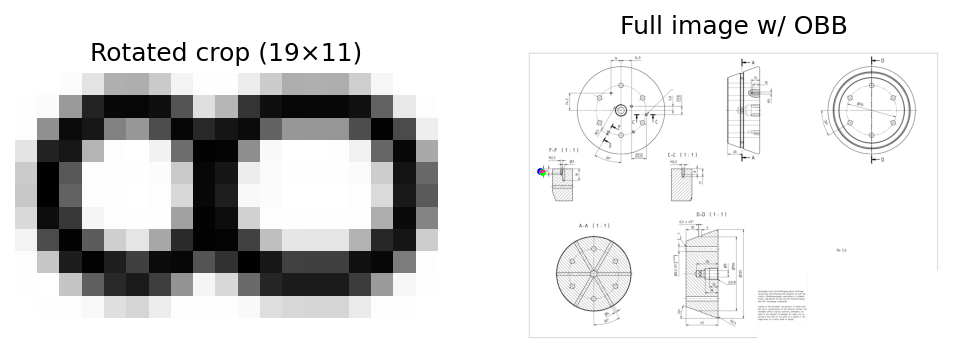

patch[[[254 254 254]
  [254 254 254]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [254 254 254]
  [240 240 240]
  [185 185 185]
  [130 130 130]
  [128 128 128]
  [126 126 126]
  [147 147 147]
  [196 196 196]
  [248 248 248]
  [254 254 254]]

 [[250 250 250]
  [247 247 247]
  [254 254 254]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [254 254 254]
  [229 229 229]
  [ 82  82  82]
  [  6   6   6]
  [  7   7   7]
  [  9   9   9]
  [  9   9   9]
  [  3   3   3]
  [ 12  12  12]
  [135 135 135]
  [250 250 250]]

 [[113 113 113]
  [ 99  99  99]
  [249 249 249]
  [253 253 253]
  [255 255 255]
  [255 255 255]
  [253 253 253]
  [241 241 241]
  [ 81  81  81]
  [  7   7   7]
  [ 94  94  94]
  [182 182 182]
  [193 193 193]
  [194 194 194]
  [156 156 156]
  [ 46  46  46]
  [  9   9   9]
  [155 155 155]]

 [[ 41  41  41]
  [ 11  11  11]
  [216 216 216]
  [253 253 253]
  [255 255 255]
  [254 254 254]
  [254 254 254]
  [185 185 18

INFO:__main__:Ann 53: 270.0° → 0.0°


logits tensor([[  6.9395, -23.9300,  -5.2023,   2.7488]])
idx 0

▶ Ann 53 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [176.04999999999998, 903.0999999999999, 10.2, 18.1, 270.0]


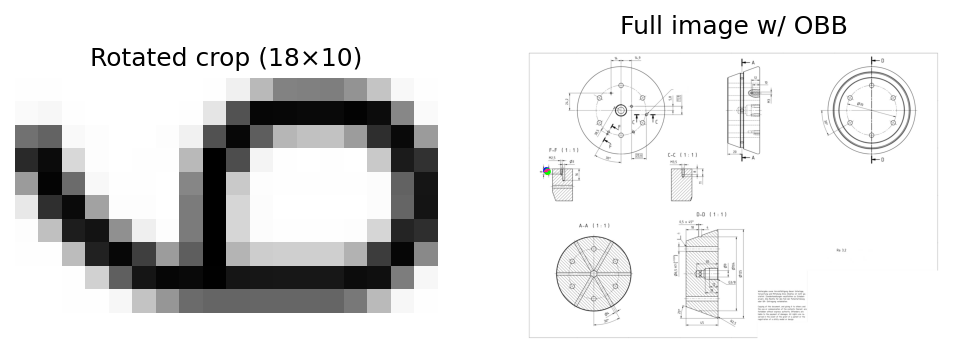

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[253 253 253]
  [239 239 239]
  [ 51  51  51]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[253 253 253]
  [155 155 155]
  [  4   4   4]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[240 240 240]
  [ 75  75  75]
  [ 13  13  13]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [1.9920, 1.9920, 1.9920,  ..., 2.2489, 2.2489, 2.2489],
          [1.9920, 1.9920, 1.9920,  ..., 2.2489, 2.2489, 2.2489],
          [1.

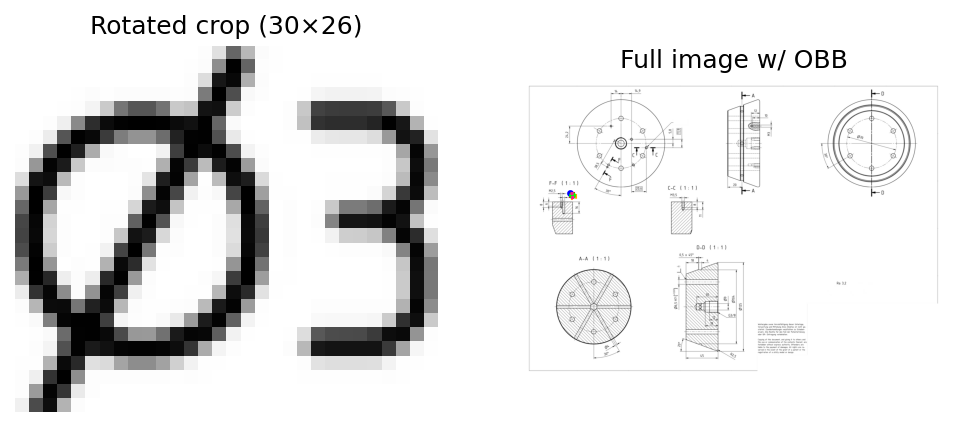

patch[[[135 135 135]
  [143 143 143]
  [252 252 252]
  ...
  [149 149 149]
  [165 165 165]
  [247 247 247]]

 [[ 24  24  24]
  [ 18  18  18]
  [194 194 194]
  ...
  [  2   2   2]
  [  3   3   3]
  [156 156 156]]

 [[ 25  25  25]
  [  1   1   1]
  [ 51  51  51]
  ...
  [159 159 159]
  [169 169 169]
  [233 233 233]]

 ...

 [[253 253 253]
  [253 253 253]
  [255 255 255]
  ...
  [253 253 253]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[0.1939, 0.1939, 0.1939,  ..., 2.1119, 2.1119, 2.1119],
          [0.1939, 0.1939, 0.1939,  ..., 2.1119, 2.1119, 2.1119],
          [0.1939, 0.1939, 0.1939,  ..., 2.1119, 2.1119, 2.1119],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

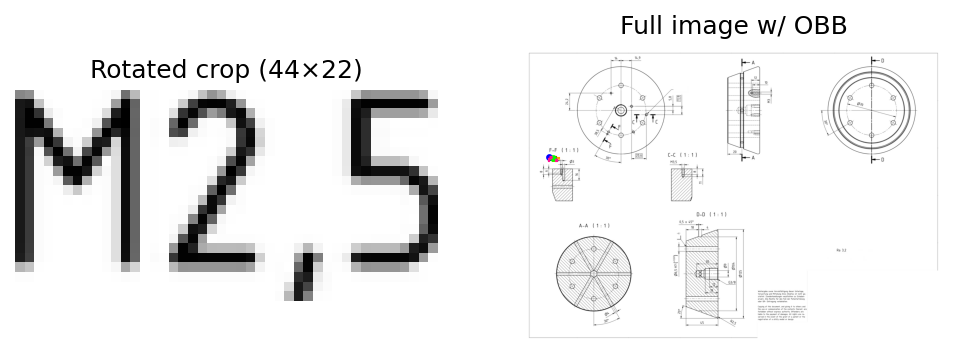

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [249 249 249]
  [253 253 253]
  [255 255 255]]

 ...

 [[254 254 254]
  [253 253 253]
  [253 253 253]
  ...
  [136 136 136]
  [253 253 253]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [238 238 238]
  [253 253 253]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 253 253]
  [254 254 254]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2489],
          [2.

INFO:__main__:Ann 57: 0.53° → 0.0°


logits tensor([[ 13.6329, -11.9873,  -9.0370,  -9.0342]])
idx 0

▶ Ann 57 on img 2 (7443.png)
  orig_rot: 0.53°, pred_rot: 0.0°
  bbox: [302.1, 751.575, 206.06, 33.25, 0.53]


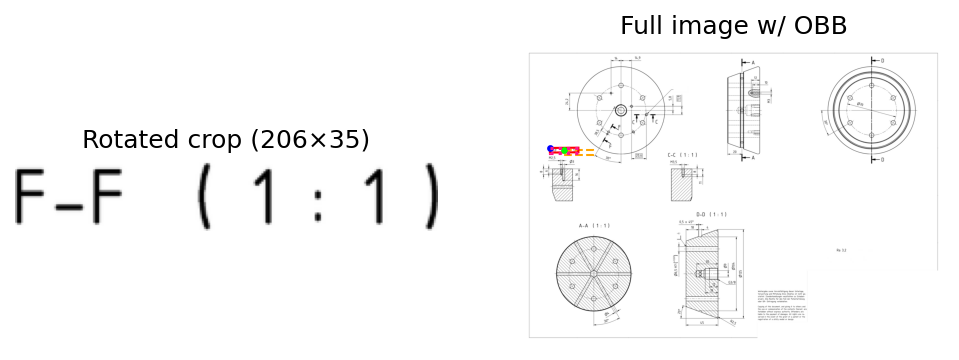

patch[[[255 255 255]
  [254 254 254]
  [241 241 241]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [224 224 224]
  [ 76  76  76]
  ...
  [255 255 255]
  [254 254 254]
  [255 255 255]]

 [[248 248 248]
  [ 84  84  84]
  [  6   6   6]
  ...
  [255 255 255]
  [254 254 254]
  [255 255 255]]

 ...

 [[248 248 248]
  [ 68  68  68]
  [  9   9   9]
  ...
  [255 255 255]
  [254 254 254]
  [255 255 255]]

 [[254 254 254]
  [200 200 200]
  [ 48  48  48]
  ...
  [255 255 255]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [220 220 220]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]]


INFO:__main__:Ann 58: 270.1° → 0.0°


Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400, 

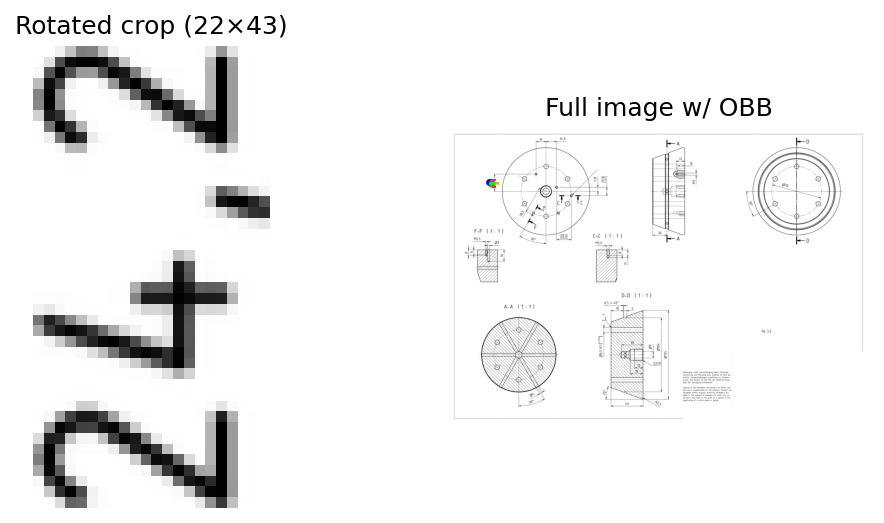

patch[[[255 255 255]
  [254 254 254]
  [244 244 244]
  ...
  [255 255 255]
  [255 255 255]
  [254 254 254]]

 [[255 255 255]
  [209 209 209]
  [ 80  80  80]
  ...
  [255 255 255]
  [255 255 255]
  [254 254 254]]

 [[227 227 227]
  [ 55  55  55]
  [  6   6   6]
  ...
  [255 255 255]
  [255 255 255]
  [254 254 254]]

 ...

 [[253 253 253]
  [183 183 183]
  [ 30  30  30]
  ...
  [255 255 255]
  [255 255 255]
  [254 254 254]]

 [[255 255 255]
  [253 253 253]
  [186 186 186]
  ...
  [255 255 255]
  [255 255 255]
  [254 254 254]]

 [[255 255 255]
  [253 253 253]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [254 254 254]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.

INFO:__main__:Ann 60: 270.0° → 0.0°


logits tensor([[ 11.6470, -21.4296, -11.8074,   2.9662]])
idx 0

▶ Ann 60 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [1132.18, 377.97, 33.5, 22.98, 270.0]


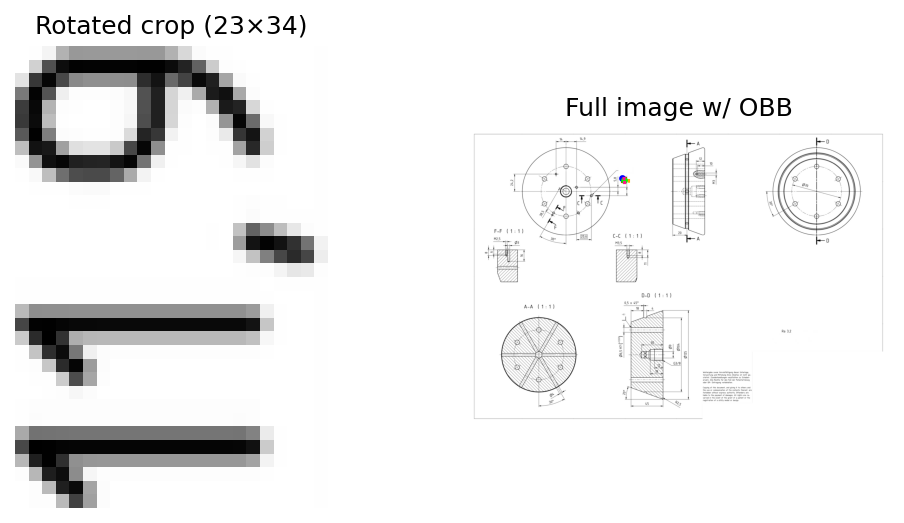

INFO:__main__:Ann 61: 270.0° → 0.0°


patch[[[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [224 224 224]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [224 224 224]
  [ 61  61  61]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[245 245 245]
  [ 83  83  83]
  [  3   3   3]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[251 251 251]
  [148 148 148]
  [ 56  56  56]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [250 250 250]
  [240 240 240]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

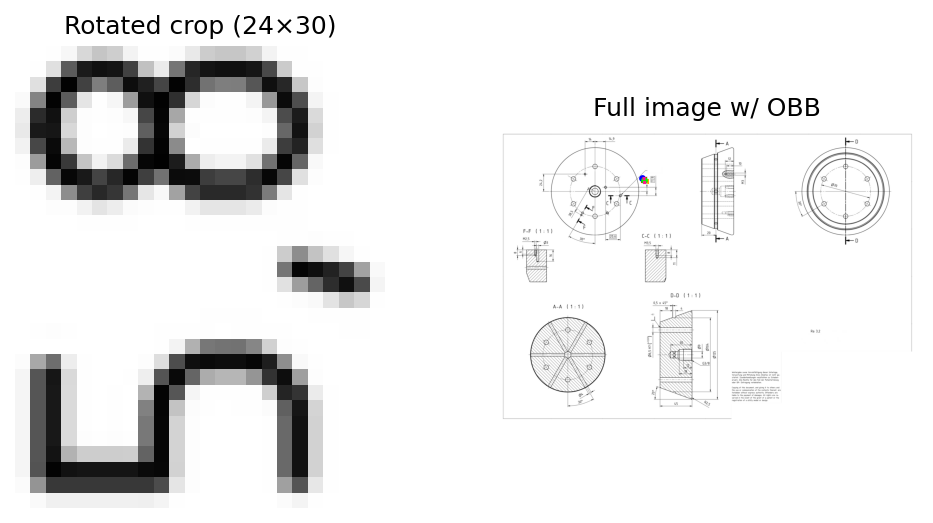

patch[[[253 253 253]
  [185 185 185]
  [ 70  70  70]
  ...
  [233 233 233]
  [254 254 254]
  [255 255 255]]

 [[181 181 181]
  [ 26  26  26]
  [ 89  89  89]
  ...
  [224 224 224]
  [254 254 254]
  [255 255 255]]

 [[ 73  73  73]
  [ 80  80  80]
  [245 245 245]
  ...
  [225 225 225]
  [254 254 254]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2147, 2.2147, 2.2147,  ..., 2.2489, 2.2489, 2.2489],
          [2.2147, 2.2147, 2.2147,  ..., 2.2489, 2.2489, 2.2489],
          [2.2147, 2.2147, 2.2147,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

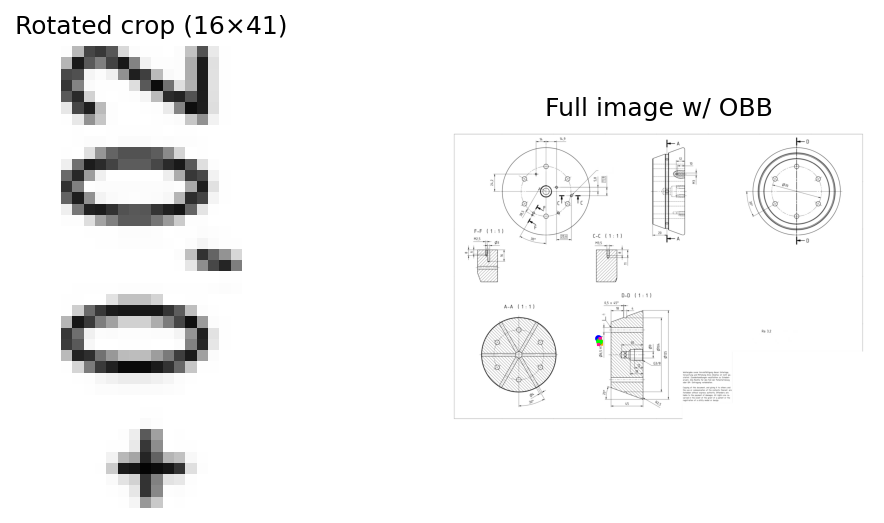

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[246 246 246]
  [ 90  90  90]
  [  1   1   1]
  ...
  [ 16  16  16]
  [  0   0   0]
  [ 97  97  97]]

 [[229 229 229]
  [ 43  43  43]
  [  1   1   1]
  ...
  [ 59  59  59]
  [  0   0   0]
  [ 61  61  61]]

 [[251 251 251]
  [167 167 167]
  [ 57  57  57]
  ...
  [186 186 186]
  [ 63  63  63]
  [174 174 174]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.1804, 2.1804, 2.1804,  ..., 0.8618, 0.8618, 0.8618],
          [2.1804, 2.1804, 2.1804,  ..., 0.8618, 0.8618, 0.8618],
          [2.

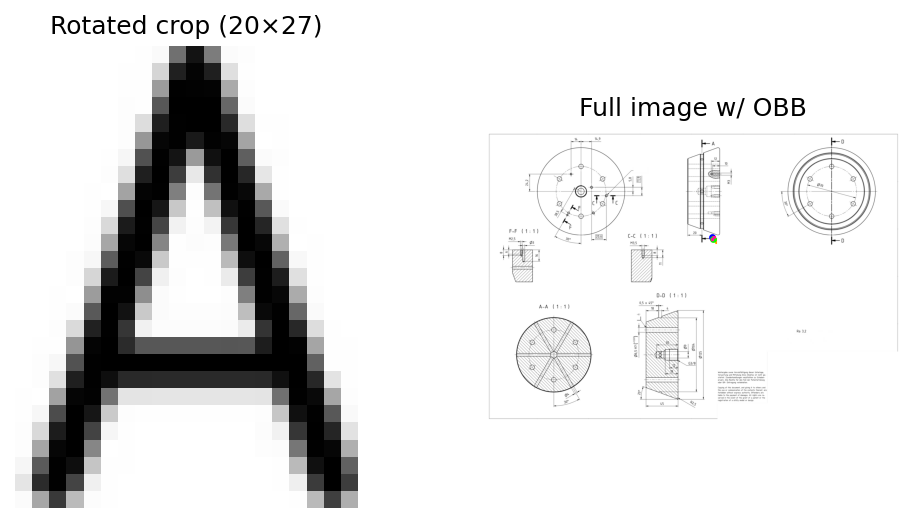

patch[[[255 255 255]
  [253 253 253]
  [219 219 219]
  ...
  [ 96  96  96]
  [207 207 207]
  [254 254 254]]

 [[254 254 254]
  [206 206 206]
  [ 40  40  40]
  ...
  [  0   0   0]
  [ 37  37  37]
  [213 213 213]]

 [[246 246 246]
  [ 73  73  73]
  [  7   7   7]
  ...
  [112 112 112]
  [  4   4   4]
  [114 114 114]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2318,  ..., 1.9578, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2318,  ..., 1.9578, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2318,  ..., 1.9578, 2.2318, 2.2318],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

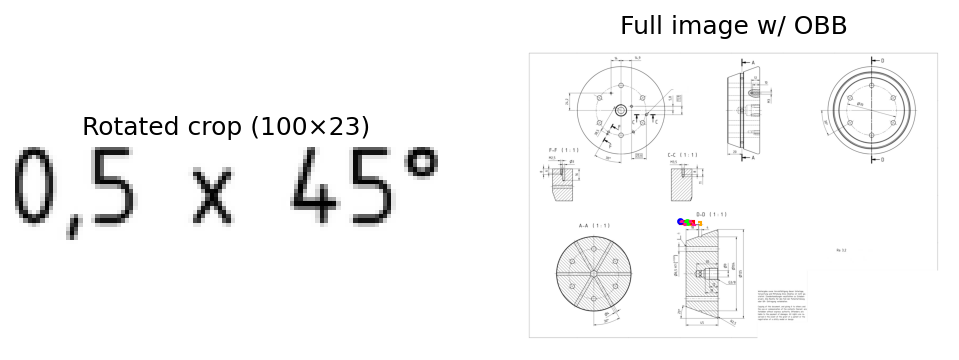

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]

 ...

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

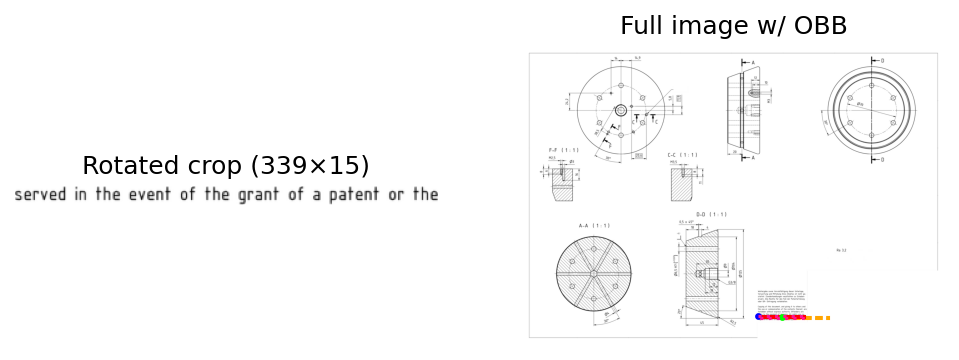

patch[[[149 149 149]
  [170 170 170]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[100 100 100]
  [131 131 131]
  [252 252 252]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[101 101 101]
  [131 131 131]
  [252 252 252]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[0.4851, 1.1529, 2.2147,  ..., 2.2489, 2.2489, 2.2489],
          [0.4851, 1.1529, 2.2147,  ..., 2.2489, 2.2489, 2.2489],
          [0.4851, 1.1529, 2.2147,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

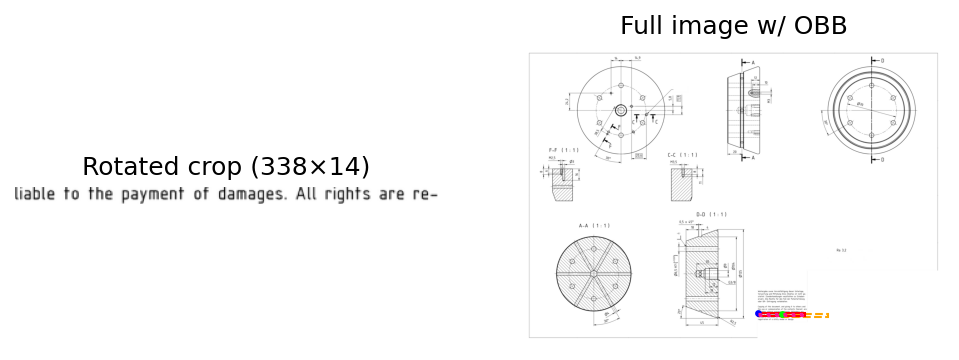

patch[[[255 255 255]
  [252 252 252]
  [224 224 224]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [182 182 182]
  [ 42  42  42]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[250 250 250]
  [ 80  80  80]
  [125 125 125]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 ...

 [[254 254 254]
  [235 235 235]
  [244 244 244]
  ...
  [224 224 224]
  [223 223 223]
  [232 232 232]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.0948, 1.5810,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.0948, 1.5810,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.0948, 1.5810,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

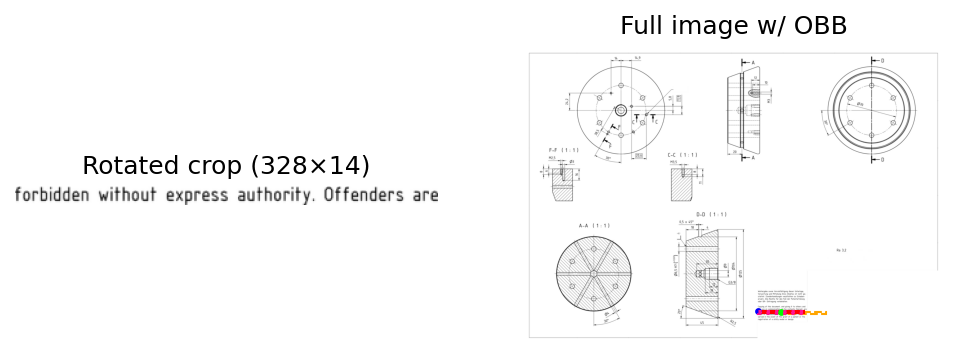

patch[[[252 252 252]
  [161 161 161]
  [201 201 201]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[249 249 249]
  [ 69  69  69]
  [147 147 147]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[250 250 250]
  [ 72  72  72]
  [151 151 151]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]

 ...

 [[252 252 252]
  [175 175 175]
  [209 209 209]
  ...
  [124 124 124]
  [122 122 122]
  [216 216 216]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]]
Tensor tensor([[[[1.9064, 0.8618, 1.7352,  ..., 2.2489, 2.2489, 2.2489],
          [1.9064, 0.8618, 1.7352,  ..., 2.2489, 2.2489, 2.2489],
          [1.9064, 0.8618, 1.7352,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2318, 2.2489,  ..., 2.2318, 2.2318, 2.2489],
          [2.2489, 2.2318, 2.2489,  ..., 2.2318, 2.2318, 2.2489],
          [2.

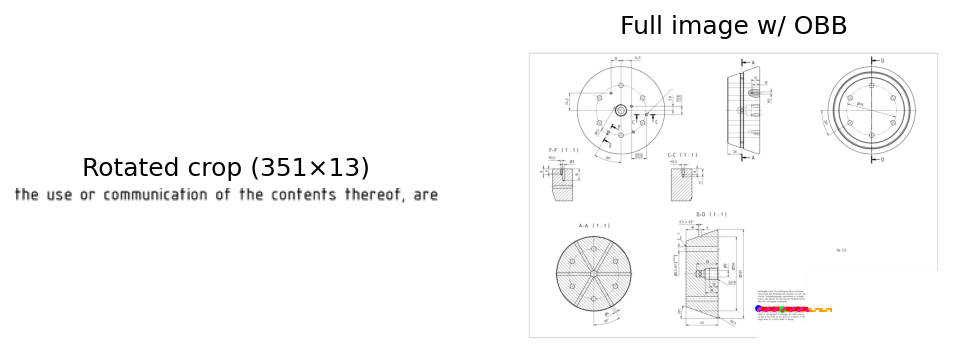

INFO:__main__:Ann 71: 270.0° → 0.0°


patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 34  34  34]
  [  2   2   2]
  [ 85  85  85]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [213 213 213]
  [130 130 130]
  [201 201 201]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 253 253]
  [253 253 253]
  [252 252 252]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.1975, 2.1975],
          [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.1975, 2.1975],
          [2.

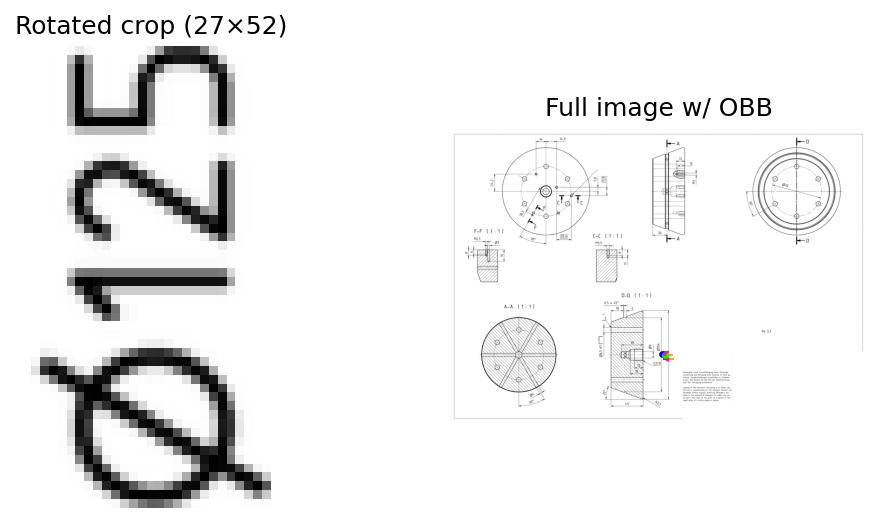

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [253 253 253]
  ...
  [220 220 220]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [253 253 253]
  [240 240 240]
  ...
  [ 38  38  38]
  [205 205 205]
  [253 253 253]]

 ...

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [ 18  18  18]
  [ 46  46  46]
  [226 226 226]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [  8   8   8]
  [173 173 173]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [185 185 185]
  [250 250 250]
  [254 254 254]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.

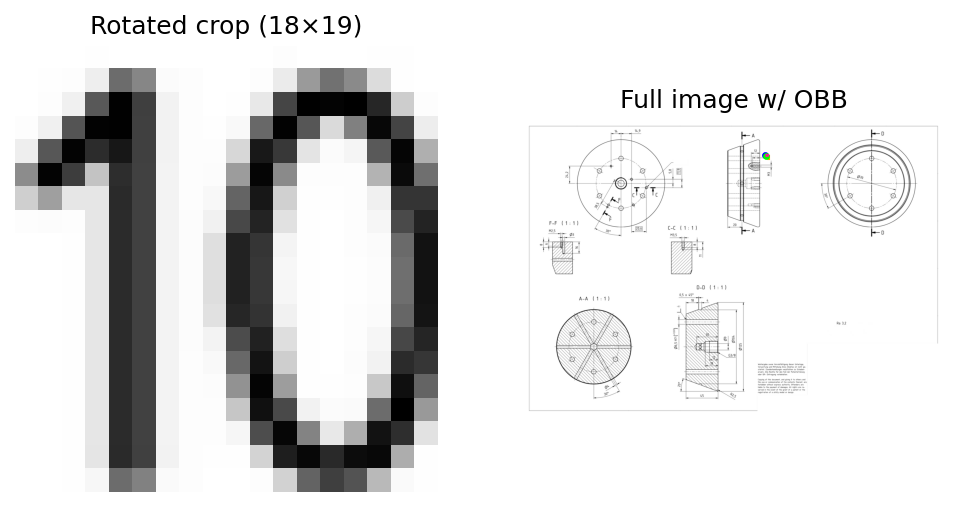

patch[[[255 255 255]
  [255 255 255]
  [252 252 252]
  ...
  [250 250 250]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [248 248 248]
  [177 177 177]
  ...
  [136 136 136]
  [241 241 241]
  [254 254 254]]

 [[253 253 253]
  [163 163 163]
  [ 20  20  20]
  ...
  [  6   6   6]
  [109 109 109]
  [247 247 247]]

 ...

 [[210 210 210]
  [ 60  60  60]
  [  2   2   2]
  ...
  [145 145 145]
  [147 147 147]
  [219 219 219]]

 [[133 133 133]
  [ 11  11  11]
  [  9   9   9]
  ...
  [ 10  10  10]
  [ 10  10  10]
  [143 143 143]]

 [[237 237 237]
  [184 184 184]
  [181 181 181]
  ...
  [181 181 181]
  [183 183 183]
  [234 234 234]]]


INFO:__main__:Ann 75: 270.0° → 0.0°


Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [1.9407, 1.9407, 1.9407,  ..., 1.8893, 1.8893, 1.8893],
          [1.9407, 1.9407, 1.9407,  ..., 1.8893, 1.8893, 1.8893],
          [1.9407, 1.9407, 1.9407,  ..., 1.8893, 1.8893, 1.8893]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.1134, 2.1134, 2.1134,  ..., 2.0609, 2.0609, 2.0609],
          [2.1134, 2.1134, 2.1134,  ..., 2.0609, 2.0609, 2.0609],
          [2.1134, 2.1134, 2.1134,  ..., 2.0609, 2.0609, 2.0609]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400, 

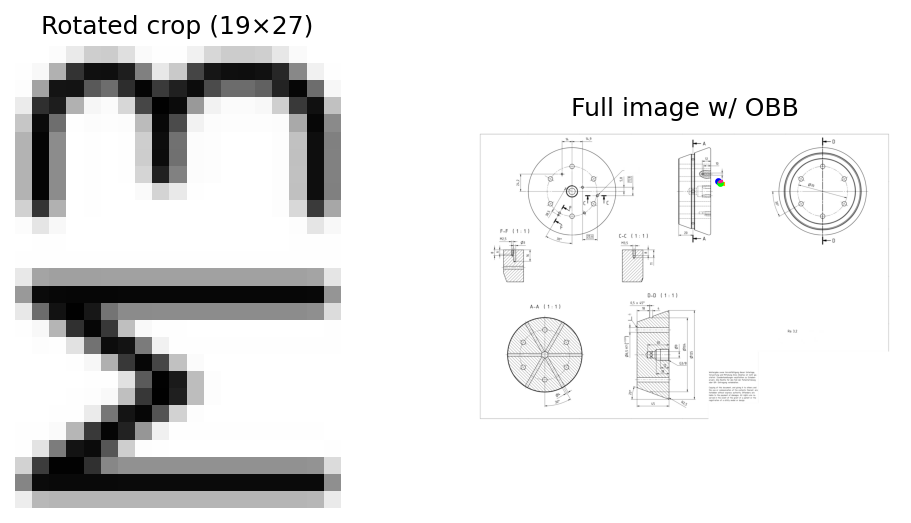

patch[[[255 255 255]
  [229 229 229]
  [241 241 241]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [112 112 112]
  [149 149 149]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 253 253]
  [139 139 139]
  [104 104 104]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [214 214 214]
  [ 65  65  65]
  [229 229 229]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [248 248 248]
  [230 230 230]
  [253 253 253]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [254 254 254]
  [255 255 255]]]
Tensor tensor([[[[2.1975, 1.8550, 2.0777,  ..., 2.2489, 2.2489, 2.2489],
          [2.1975, 1.8550, 2.0777,  ..., 2.2489, 2.2489, 2.2489],
          [2.1975, 1.8550, 2.0777,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2318, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2318, 2.2489],
          [2.

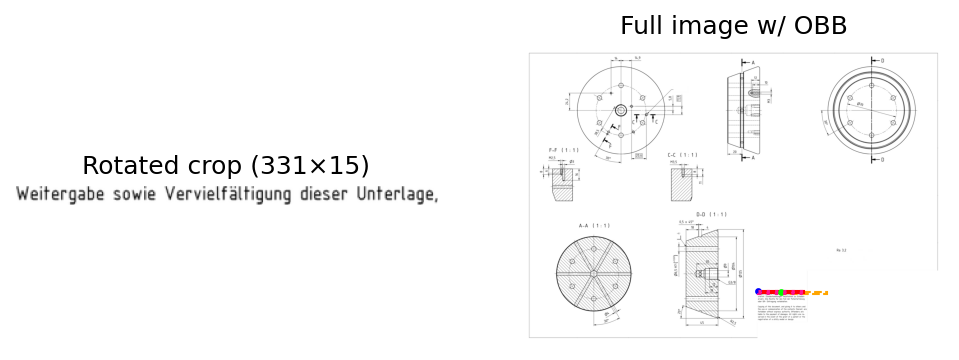

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[248 248 248]
  [239 239 239]
  [239 239 239]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [254 254 254]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

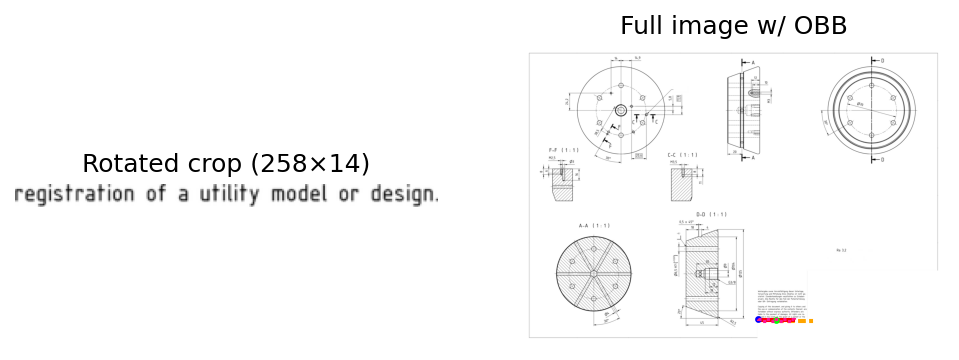

patch[[[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [249 249 249]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[253 253 253]
  [250 250 250]
  [139 139 139]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [252 252 252]
  ...
  [192 192 192]
  [253 253 253]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [253 253 253]
  ...
  [231 231 231]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

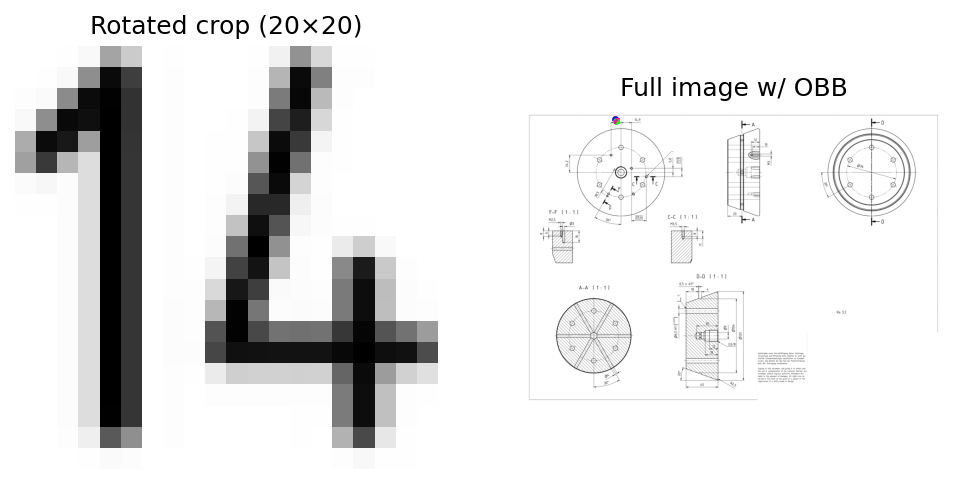

patch[[[240 240 240]
  [158 158 158]
  [140 140 140]
  ...
  [140 140 140]
  [142 142 142]
  [219 219 219]]

 [[129 129 129]
  [  3   3   3]
  [  0   0   0]
  ...
  [  0   0   0]
  [  1   1   1]
  [ 85  85  85]]

 [[104 104 104]
  [  3   3   3]
  [  0   0   0]
  ...
  [ 19  19  19]
  [ 20  20  20]
  [116 116 116]]

 ...

 [[105 105 105]
  [  5   5   5]
  [  9   9   9]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[105 105 105]
  [  7   7   7]
  [ 10  10  10]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[138 138 138]
  [ 11  11  11]
  [ 31  31  31]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[1.9920, 1.9920, 1.9920,  ..., 1.6324, 1.6324, 1.6324],
          [1.9920, 1.9920, 1.9920,  ..., 1.6324, 1.6324, 1.6324],
          [1.9920, 1.9920, 1.9920,  ..., 1.6324, 1.6324, 1.6324],
          ...,
          [0.2453, 0.2453, 0.2453,  ..., 2.2489, 2.2489, 2.2489],
          [0.2453, 0.2453, 0.2453,  ..., 2.2489, 2.2489, 2.2489],
          [0.

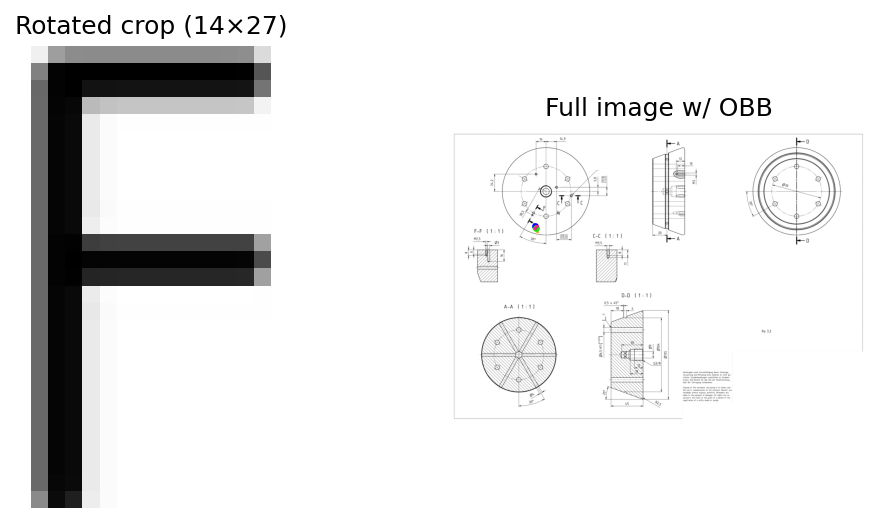

patch[[[217 217 217]
  [133 133 133]
  [125 125 125]
  ...
  [130 130 130]
  [222 222 222]
  [254 254 254]]

 [[ 98  98  98]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [115 115 115]
  [255 255 255]]

 [[ 87  87  87]
  [  0   0   0]
  [  4   4   4]
  ...
  [ 26  26  26]
  [154 154 154]
  [254 254 254]]

 ...

 [[ 87  87  87]
  [  0   0   0]
  [ 40  40  40]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[ 88  88  88]
  [  2   2   2]
  [ 41  41  41]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[124 124 124]
  [ 14  14  14]
  [ 71  71  71]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[1.5982, 1.5982, 1.5982,  ..., 2.2318, 2.2318, 2.2318],
          [1.5982, 1.5982, 1.5982,  ..., 2.2318, 2.2318, 2.2318],
          [1.5982, 1.5982, 1.5982,  ..., 2.2318, 2.2318, 2.2318],
          ...,
          [0.0056, 0.0056, 0.0056,  ..., 2.2489, 2.2489, 2.2489],
          [0.0056, 0.0056, 0.0056,  ..., 2.2489, 2.2489, 2.2489],
          [0.

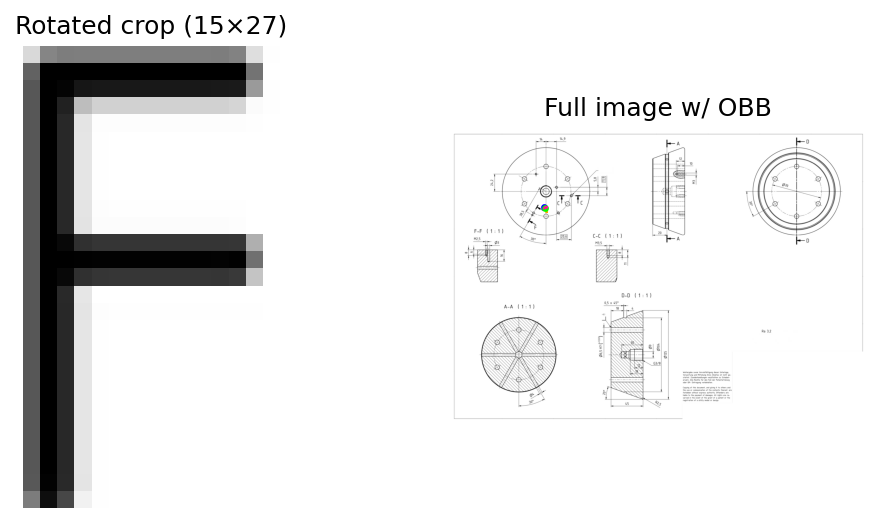

patch[[[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [189 189 189]
  [253 253 253]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [238 238 238]
  ...
  [ 31  31  31]
  [185 185 185]
  [254 254 254]]

 [[253 253 253]
  [239 239 239]
  [ 90  90  90]
  ...
  [  0   0   0]
  [ 34  34  34]
  [184 184 184]]

 ...

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [223 223 223]
  [222 222 222]
  [237 237 237]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [ 25  25  25]
  [ 25  25  25]
  [104 104 104]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 53  53  53]
  [ 53  53  53]
  [129 129 129]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 0.0912, 0.0912, 0.0912],
          [2.2489, 2.2489, 2.2489,  ..., 0.0912, 0.0912, 0.0912],
          [2.

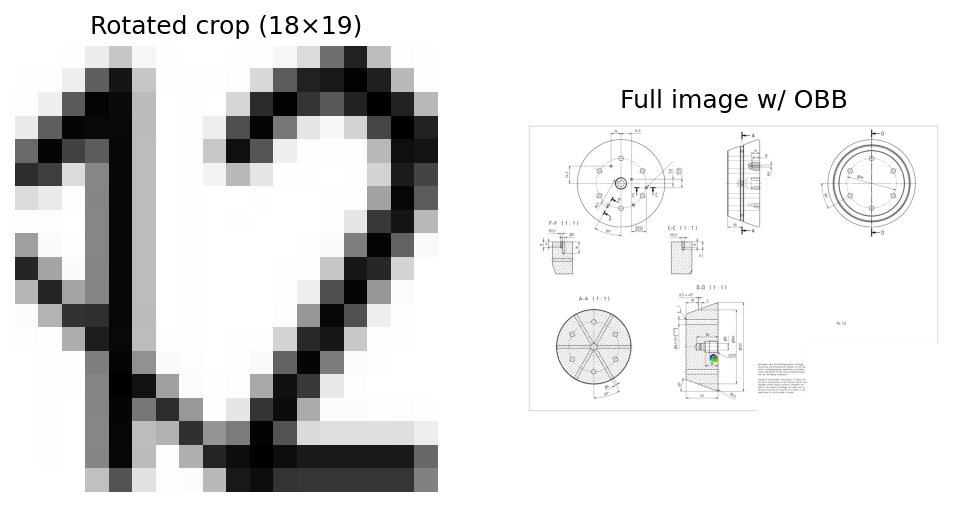

patch[[[194 194 194]
  [220 220 220]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[112 112 112]
  [122 122 122]
  [252 252 252]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[192 192 192]
  [ 68  68  68]
  [235 235 235]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[1.2899, 1.8208, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [1.2899, 1.8208, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [1.2899, 1.8208, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

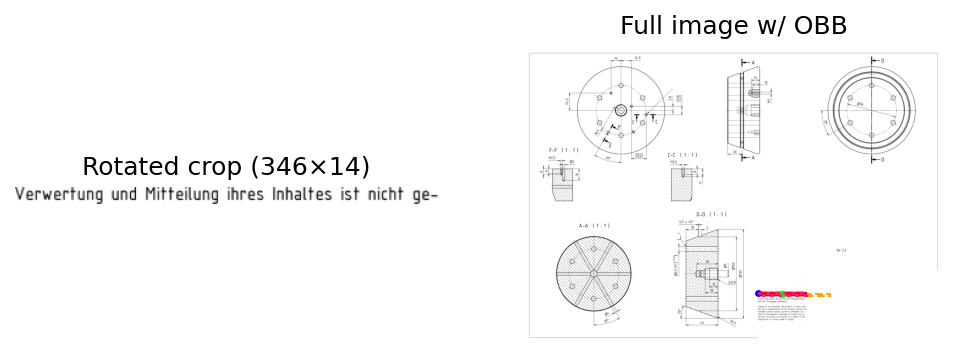

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [253 253 253]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[254 254 254]
  [252 252 252]
  [253 253 253]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

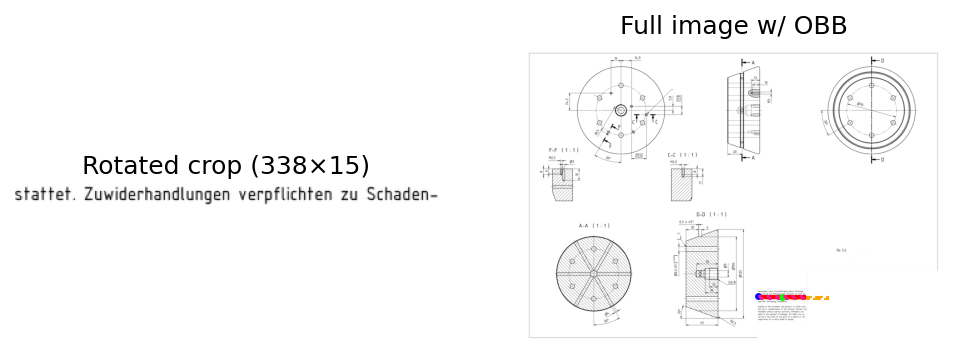

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [253 253 253]
  [253 253 253]
  [254 254 254]]

 [[254 254 254]
  [254 254 254]
  [231 231 231]
  ...
  [219 219 219]
  [220 220 220]
  [248 248 248]]

 ...

 [[255 255 255]
  [254 254 254]
  [253 253 253]
  ...
  [217 217 217]
  [ 57  57  57]
  [189 189 189]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 34  34  34]
  [ 72  72  72]
  [238 238 238]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [200 200 200]
  [241 241 241]
  [254 254 254]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 1.2899, 1.8379, 2.1975],
          [2.2489, 2.2489, 2.2489,  ..., 1.2899, 1.8379, 2.1975],
          [2.

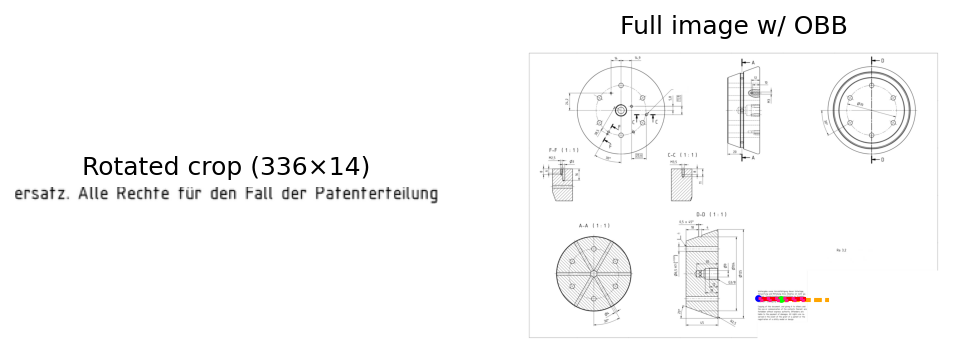

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[254 254 254]
  [253 253 253]
  [253 253 253]
  ...
  [255 255 255]
  [254 254 254]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

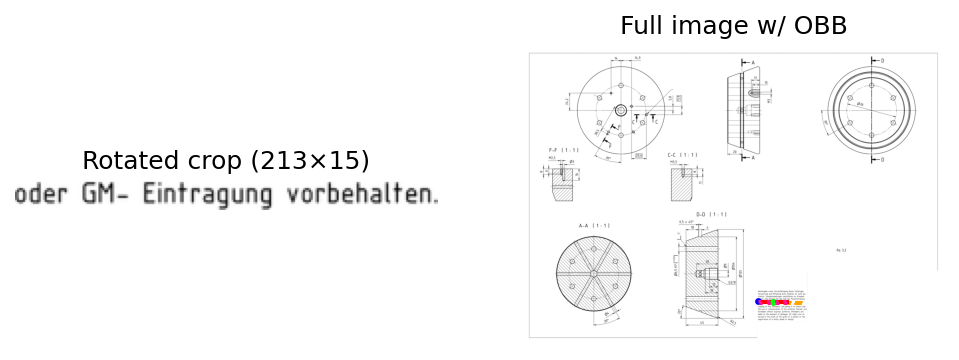

patch[[[251 251 251]
  [168 168 168]
  [ 75  75  75]
  ...
  [224 224 224]
  [ 99  99  99]
  [233 233 233]]

 [[176 176 176]
  [ 37  37  37]
  [163 163 163]
  ...
  [211 211 211]
  [ 33  33  33]
  [224 224 224]]

 [[103 103 103]
  [122 122 122]
  [253 253 253]
  ...
  [209 209 209]
  [ 35  35  35]
  [225 225 225]]

 ...

 [[255 255 255]
  [254 254 254]
  [253 253 253]
  ...
  [254 254 254]
  [254 254 254]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[ 1.9407,  0.3309, -0.9534,  ...,  1.9064,  0.1597,  1.4954],
          [ 1.9407,  0.3309, -0.9534,  ...,  1.9064,  0.1597,  1.4954],
          [ 1.9407,  0.3309, -0.9534,  ...,  1.9064,  0.1597,  1.4954],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2

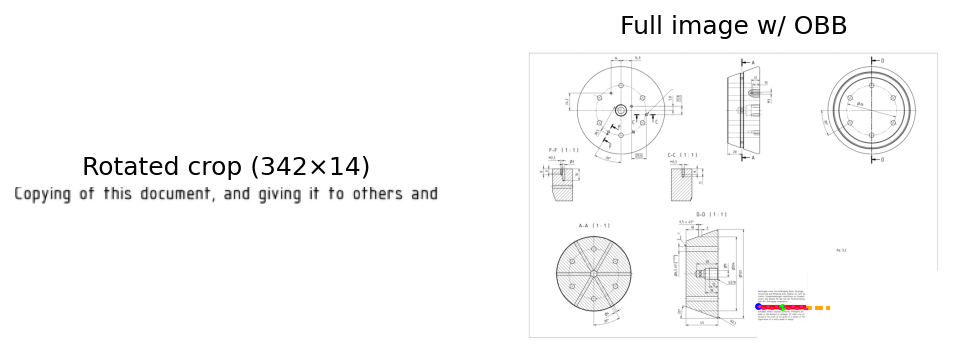

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 253 253]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

INFO:__main__:Ann 88: 0.53° → 0.0°


logits tensor([[ 12.3751,  -7.8842, -12.1037,  -7.8502]])
idx 0

▶ Ann 88 on img 2 (7443.png)
  orig_rot: 0.53°, pred_rot: 0.0°
  bbox: [1158.31, 786.35, 206.2, 34.3, 0.53]


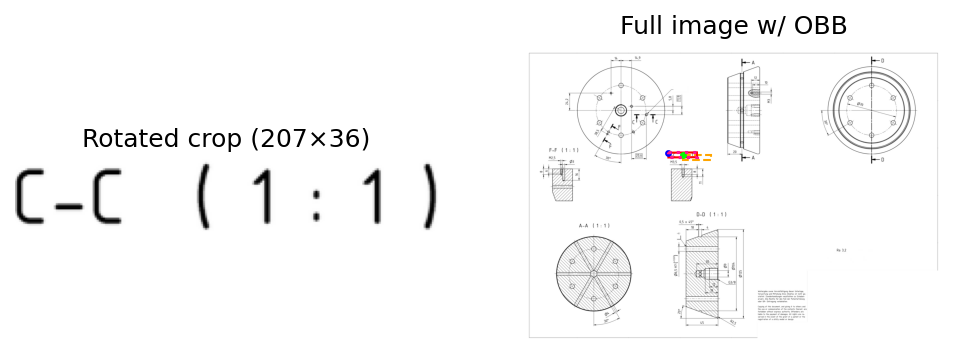

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [242 242 242]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [251 251 251]
  ...
  [106 106 106]
  [249 249 249]
  [253 253 253]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

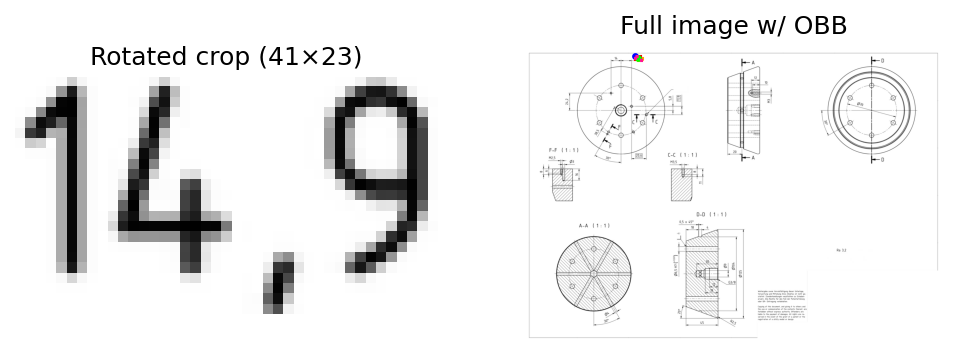

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [  7   7   7]
  [121 121 121]
  [252 252 252]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [151 151 151]
  [224 224 224]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

INFO:__main__:Ann 90: 0.0° → 90.0°


logits tensor([[ -3.8861, -15.2360, -10.3880,  13.2479]])
idx 3

▶ Ann 90 on img 2 (7443.png)
  orig_rot: 0.0°, pred_rot: 90.0°
  bbox: [1110.14, 1620.0549999999998, 26.92, 84.89, 0.0]


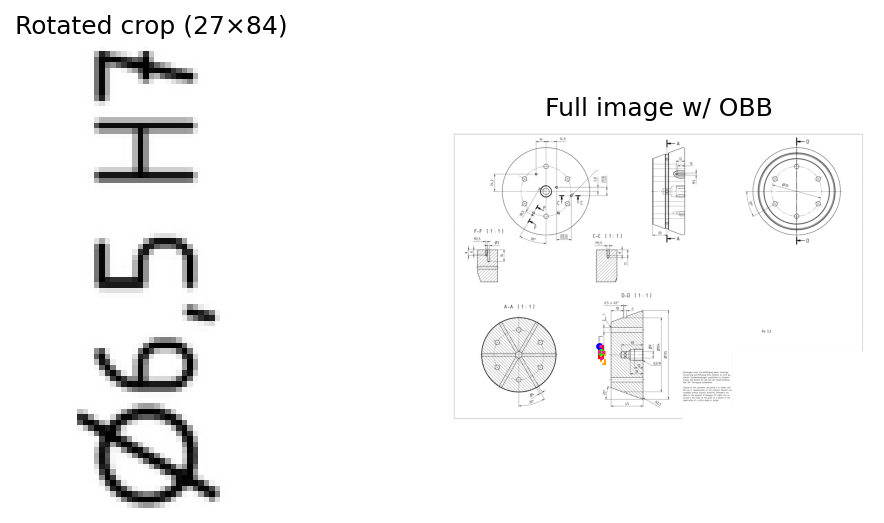

patch[[[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [ 82  82  82]
  [142 142 142]
  [248 248 248]]

 [[255 255 255]
  [254 254 254]
  [239 239 239]
  ...
  [  0   0   0]
  [ 25  25  25]
  [229 229 229]]

 [[255 255 255]
  [245 245 245]
  [102 102 102]
  ...
  [ 45  45  45]
  [103 103 103]
  [242 242 242]]

 ...

 [[255 255 255]
  [253 253 253]
  [210 210 210]
  ...
  [  0   0   0]
  [ 28  28  28]
  [230 230 230]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [ 26  26  26]
  [ 88  88  88]
  [240 240 240]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [213 213 213]
  [243 243 243]
  [254 254 254]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.1290, 2.1290, 2.1290],
          [2.2489, 2.2489, 2.2489,  ..., 2.1290, 2.1290, 2.1290],
          [2.2489, 2.2489, 2.2489,  ..., 2.1290, 2.1290, 2.1290],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.

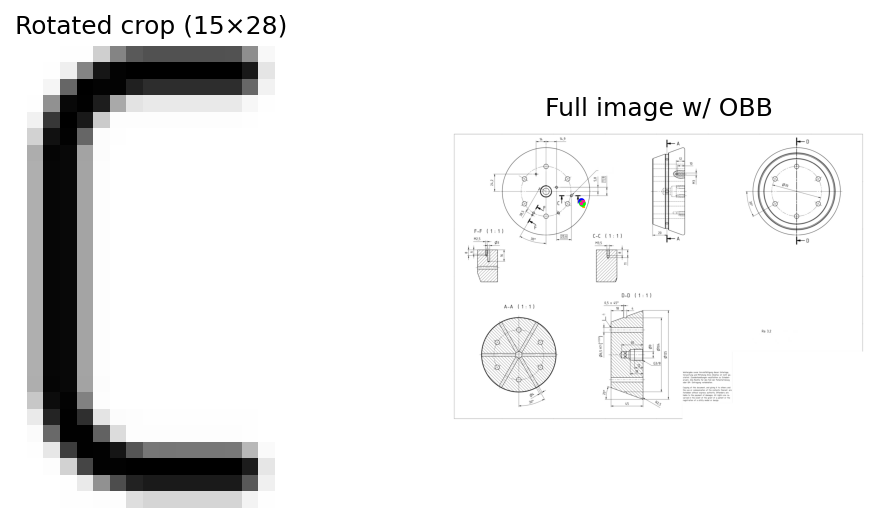

patch[[[255 255 255]
  [254 254 254]
  [253 253 253]
  ...
  [ 37  37  37]
  [ 38  38  38]
  [155 155 155]]

 [[254 254 254]
  [254 254 254]
  [200 200 200]
  ...
  [  2   2   2]
  [  2   2   2]
  [ 57  57  57]]

 [[254 254 254]
  [214 214 214]
  [ 42  42  42]
  ...
  [ 74  74  74]
  [ 78  78  78]
  [178 178 178]]

 ...

 [[255 255 255]
  [255 255 255]
  [206 206 206]
  ...
  [  3   3   3]
  [  3   3   3]
  [ 63  63  63]]

 [[255 255 255]
  [254 254 254]
  [253 253 253]
  ...
  [ 26  26  26]
  [ 29  29  29]
  [157 157 157]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [245 245 245]
  [246 246 246]
  [253 253 253]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 0.5364, 0.5364, 0.5364],
          [2.2489, 2.2489, 2.2489,  ..., 0.5364, 0.5364, 0.5364],
          [2.2489, 2.2489, 2.2489,  ..., 0.5364, 0.5364, 0.5364],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2147, 2.2147, 2.2147],
          [2.2489, 2.2489, 2.2489,  ..., 2.2147, 2.2147, 2.2147],
          [2.

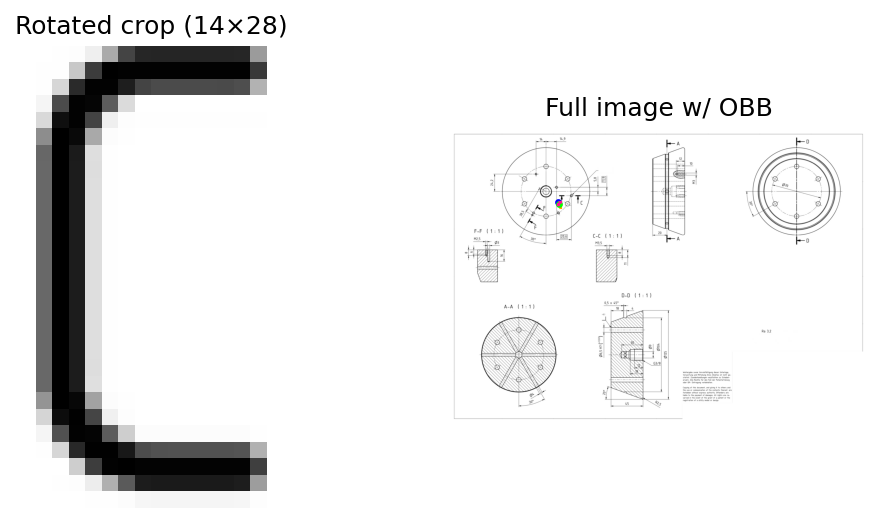

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [192 192 192]
  [171 171 171]
  [252 252 252]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 253 253]
  [252 252 252]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

INFO:__main__:Ann 93: 90.0° → 0.0°


logits tensor([[  4.2018, -13.2509,  -2.4365,  -2.7980]])
idx 0

▶ Ann 93 on img 2 (7443.png)
  orig_rot: 90.0°, pred_rot: 0.0°
  bbox: [1467.425, 1588.775, 31.75, 27.05, 90.0]


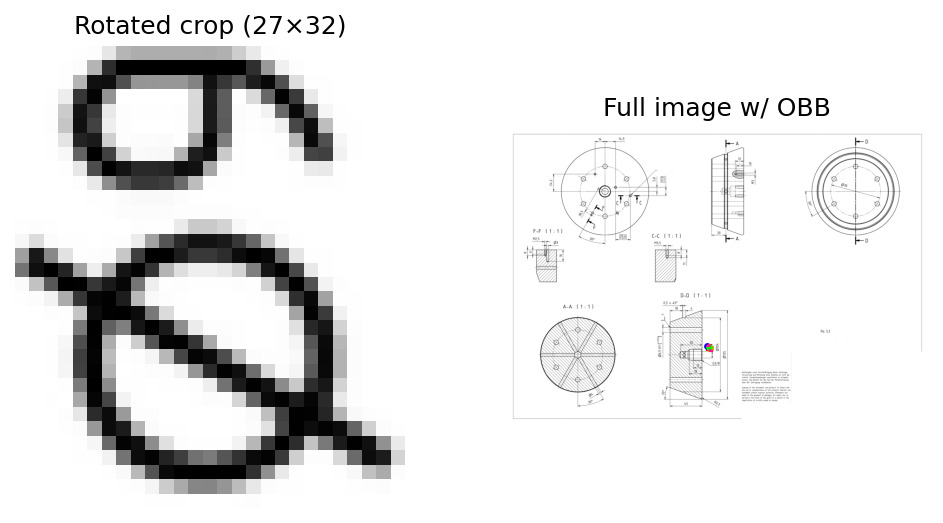

patch[[[255 255 255]
  [253 253 253]
  [252 252 252]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[252 252 252]
  [196 196 196]
  [180 180 180]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[223 223 223]
  [ 37  37  37]
  [  9   9   9]
  ...
  [239 239 239]
  [254 254 254]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

INFO:__main__:Ann 94: 0.5° → 0.0°


logits tensor([[ 11.9488, -14.9949,  -8.6907,  -4.6573]])
idx 0

▶ Ann 94 on img 2 (7443.png)
  orig_rot: 0.5°, pred_rot: 0.0°
  bbox: [2306.8999999999996, 1476.0900000000001, 67.4, 23.38, 0.5]


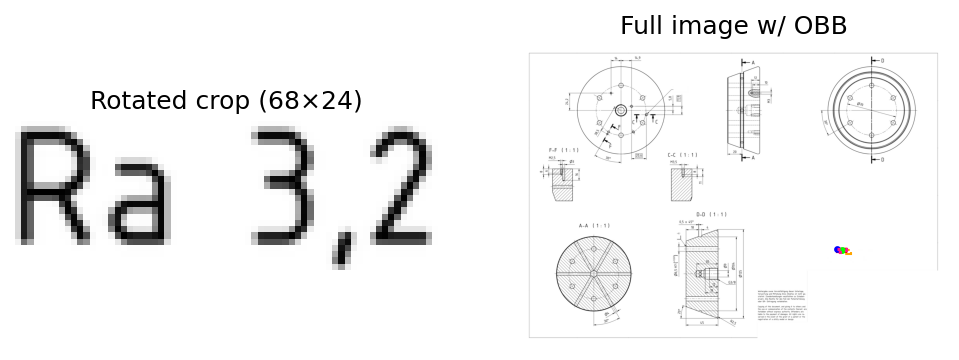

patch[[[254 254 254]
  [236 236 236]
  [232 232 232]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[199 199 199]
  [ 53  53  53]
  [ 44  44  44]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[154 154 154]
  [  3   3   3]
  [  1   1   1]
  ...
  [253 253 253]
  [254 254 254]
  [255 255 255]]

 ...

 [[153 153 153]
  [  2   2   2]
  [  1   1   1]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]

 [[189 189 189]
  [ 37  37  37]
  [ 28  28  28]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[252 252 252]
  [227 227 227]
  [223 223 223]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.1975, 2.1975, 2.1975,  ..., 2.2489, 2.2489, 2.2489],
          [2.1975, 2.1975, 2.1975,  ..., 2.2489, 2.2489, 2.2489],
          [2.

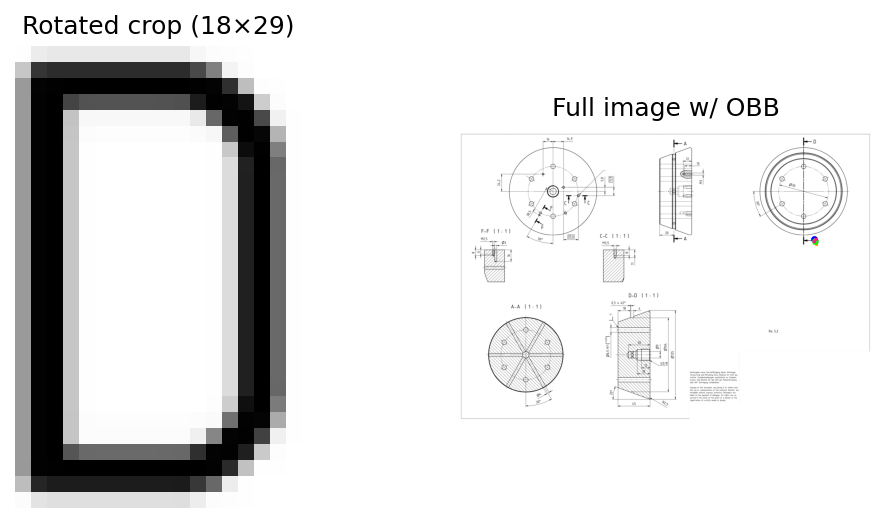

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 33  33  33]
  [110 110 110]
  [246 246 246]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [222 222 222]
  [238 238 238]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

INFO:__main__:Ann 98: 270.0° → 90.0°


logits tensor([[  1.0642, -17.7111,  -3.3067,   3.9330]])
idx 3

▶ Ann 98 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 90.0°
  bbox: [1526.3999999999999, 1590.8000000000002, 53.6, 26.8, 270.0]


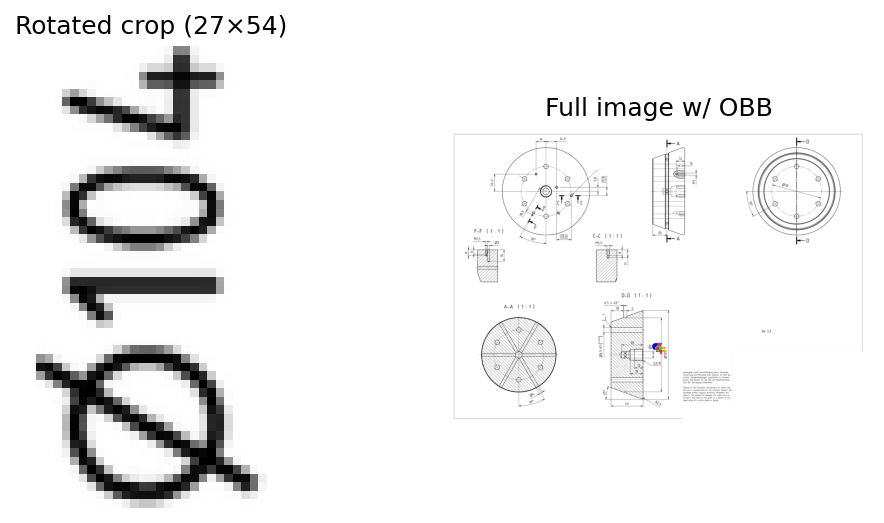

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[101 101 101]
  [  0   0   0]
  [  6   6   6]
  ...
  [ 11  11  11]
  [  0   0   0]
  [109 109 109]]

 [[ 49  49  49]
  [  1   1   1]
  [ 51  51  51]
  ...
  [ 44  44  44]
  [  1   1   1]
  [ 63  63  63]]

 [[122 122 122]
  [ 40  40  40]
  [145 145 145]
  ...
  [142 142 142]
  [ 44  44  44]
  [126 126 126]]]
Tensor tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
          ...,
          [-0.0287, -0.0287, -0.0287,  ...,  0.0398,  0.0398,  0.0398],
          [-0.0287, -0.0287, -0.0287,  ...,  0.0398,  0

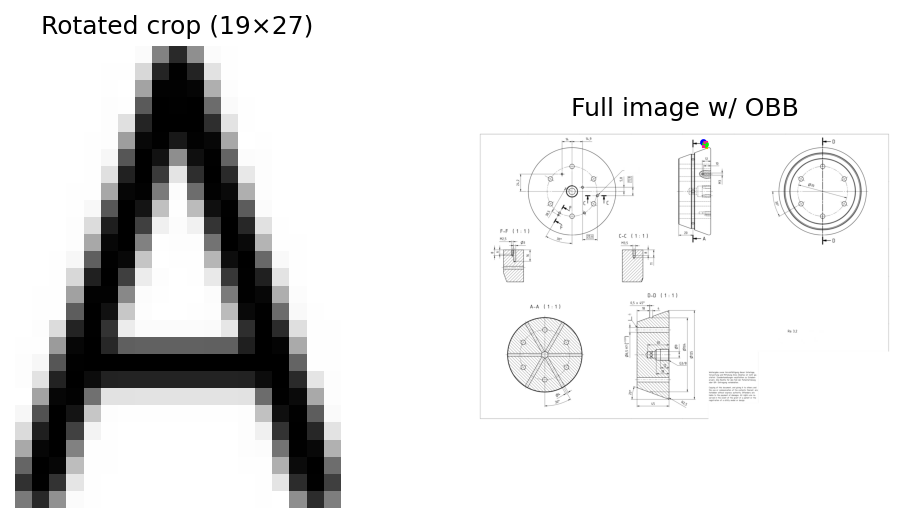

patch[[[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [253 253 253]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [253 253 253]
  [239 239 239]
  ...
  [174 174 174]
  [242 242 242]
  [254 254 254]]

 [[254 254 254]
  [249 249 249]
  [117 117 117]
  ...
  [  2   2   2]
  [148 148 148]
  [253 253 253]]

 ...

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [  2   2   2]
  [100 100 100]
  [246 246 246]]

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [114 114 114]
  [240 240 240]
  [254 254 254]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [252 252 252]
  [253 253 253]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

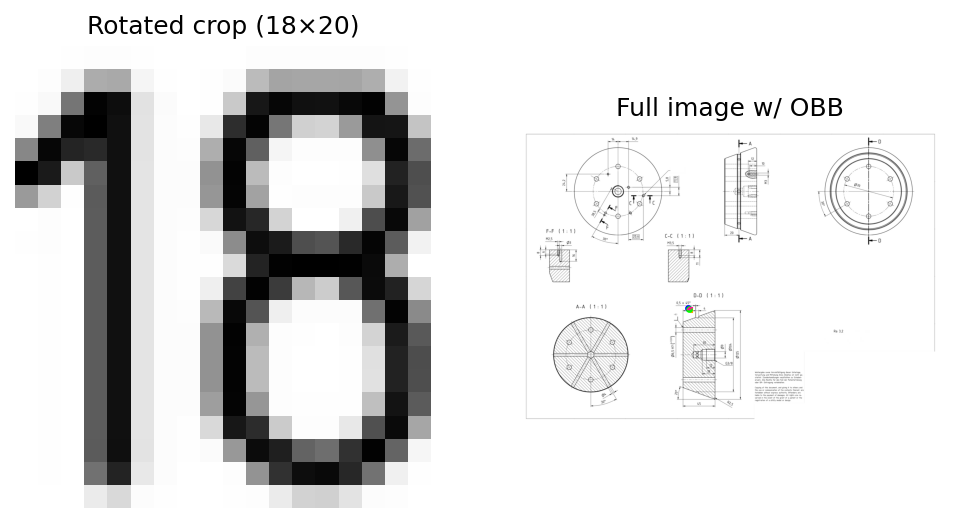

patch[[[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [147 147 147]
  [179 179 179]
  [246 246 246]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [  5   5   5]
  [ 31  31  31]
  [215 215 215]]

 [[255 255 255]
  [253 253 253]
  [250 250 250]
  ...
  [176 176 176]
  [198 198 198]
  [250 250 250]]

 ...

 [[253 253 253]
  [253 253 253]
  [253 253 253]
  ...
  [ 26  26  26]
  [ 22  22  22]
  [190 190 190]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [ 37  37  37]
  [175 175 175]
  [253 253 253]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [217 217 217]
  [253 253 253]
  [254 254 254]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.0948, 2.0948, 2.0948],
          [2.2489, 2.2489, 2.2489,  ..., 2.0948, 2.0948, 2.0948],
          [2.2489, 2.2489, 2.2489,  ..., 2.0948, 2.0948, 2.0948],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2318, 2.2318],
          [2.

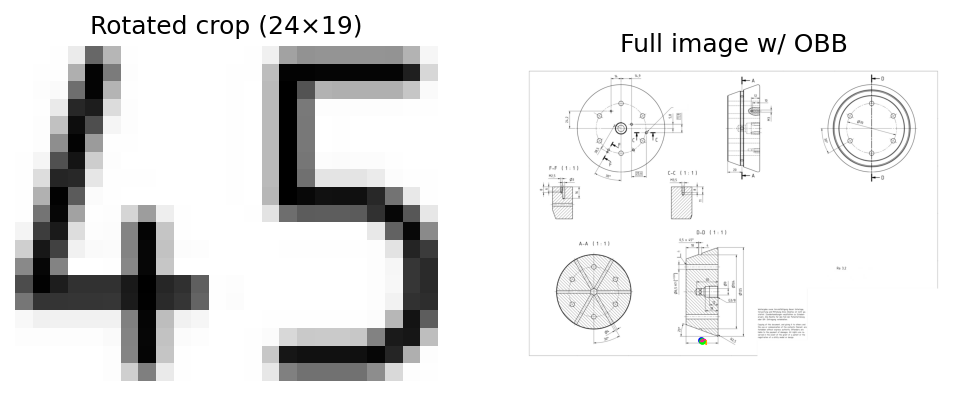

patch[[[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [232 232 232]
  [254 254 254]
  [254 254 254]]

 [[254 254 254]
  [253 253 253]
  [206 206 206]
  ...
  [ 86  86  86]
  [242 242 242]
  [254 254 254]]

 ...

 [[255 255 255]
  [255 255 255]
  [253 253 253]
  ...
  [231 231 231]
  [242 242 242]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [253 253 253]
  ...
  [ 17  17  17]
  [ 97  97  97]
  [249 249 249]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [ 87  87  87]
  [150 150 150]
  [252 252 252]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.1975, 2.1975],
          [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.1975, 2.1975],
          [2.

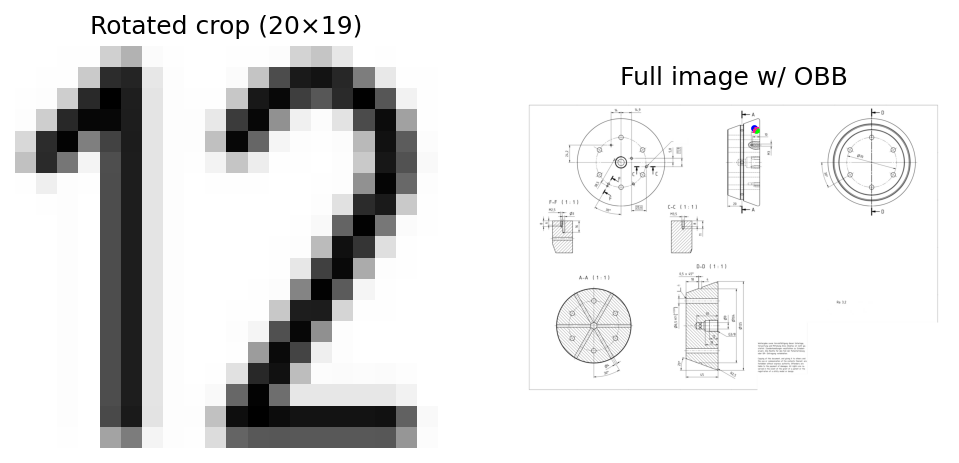

patch[[[254 254 254]
  [254 254 254]
  [239 239 239]
  ...
  [252 252 252]
  [254 254 254]
  [255 255 255]]

 [[253 253 253]
  [195 195 195]
  [ 53  53  53]
  ...
  [139 139 139]
  [249 249 249]
  [254 254 254]]

 [[201 201 201]
  [ 46  46  46]
  [  9   9   9]
  ...
  [ 21  21  21]
  [198 198 198]
  [254 254 254]]

 ...

 [[101 101 101]
  [  3   3   3]
  [ 33  33  33]
  ...
  [ 22  22  22]
  [203 203 203]
  [254 254 254]]

 [[ 23  23  23]
  [  4   4   4]
  [  2   2   2]
  ...
  [158 158 158]
  [251 251 251]
  [254 254 254]]

 [[180 180 180]
  [163 163 163]
  [163 163 163]
  ...
  [255 255 255]
  [254 254 254]
  [255 255 255]]]
Tensor tensor([[[[2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [0.9646, 0.9646, 0.9646,  ..., 2.2489, 2.2489, 2.2489],
          [0.9646, 0.9646, 0.9646,  ..., 2.2489, 2.2489, 2.2489],
          [0.

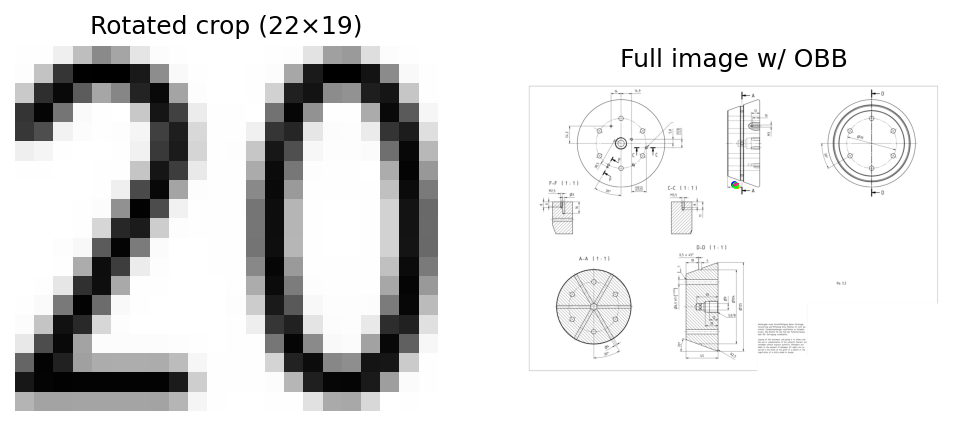

patch[[[246 246 246]
  [187 187 187]
  [170 170 170]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]

 [[185 185 185]
  [ 17  17  17]
  [  8   8   8]
  ...
  [221 221 221]
  [254 254 254]
  [254 254 254]]

 [[242 242 242]
  [184 184 184]
  [172 172 172]
  ...
  [ 68  68  68]
  [239 239 239]
  [254 254 254]]

 ...

 [[225 225 225]
  [116 116 116]
  [ 95  95  95]
  ...
  [106 106 106]
  [247 247 247]
  [254 254 254]]

 [[195 195 195]
  [ 30  30  30]
  [ 14  14  14]
  ...
  [237 237 237]
  [254 254 254]
  [255 255 255]]

 [[253 253 253]
  [244 244 244]
  [242 242 242]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.0948, 2.0948, 2.0948,  ..., 2.2489, 2.2489, 2.2489],
          [2.0948, 2.0948, 2.0948,  ..., 2.2489, 2.2489, 2.2489],
          [2.0948, 2.0948, 2.0948,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2147, 2.2147, 2.2147,  ..., 2.2489, 2.2489, 2.2489],
          [2.2147, 2.2147, 2.2147,  ..., 2.2489, 2.2489, 2.2489],
          [2.

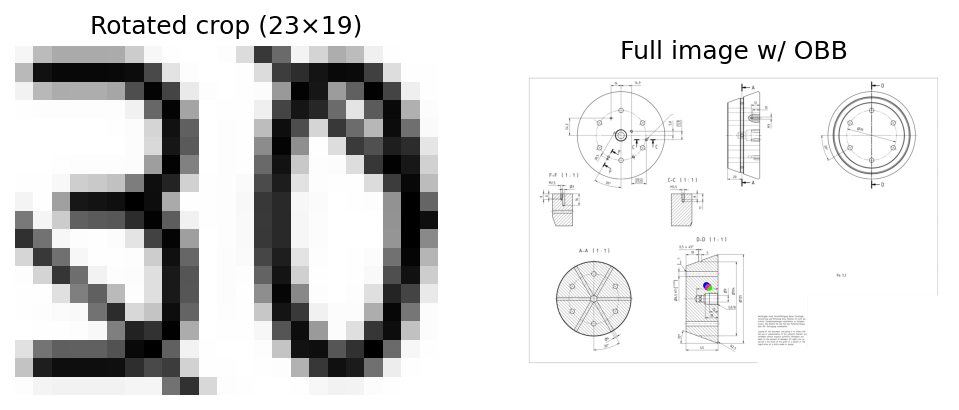

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [253 253 253]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [231 231 231]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [235 235 235]
  [212 212 212]
  ...
  [177 177 177]
  [254 254 254]
  [254 254 254]]

 ...

 [[255 255 255]
  [252 252 252]
  [247 247 247]
  ...
  [191 191 191]
  [254 254 254]
  [254 254 254]]

 [[255 255 255]
  [254 254 254]
  [254 254 254]
  ...
  [238 238 238]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [254 254 254]
  [255 255 255]
  [255 255 255]]]
Tensor tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2318, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.

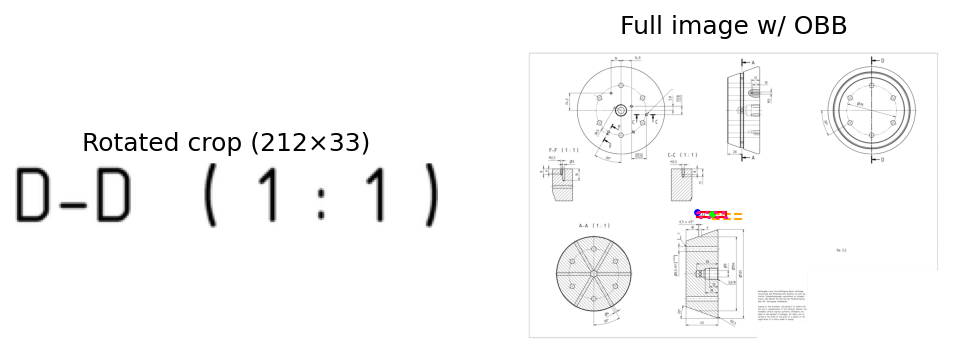

patch[[[255 255 255]
  [255 255 255]
  [254 254 254]
  [218 218 218]
  [165 165 165]
  [209 209 209]
  [254 254 254]
  [254 254 254]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [253 253 253]
  [128 128 128]
  [  6   6   6]
  [164 164 164]
  [253 253 253]
  [254 254 254]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [243 243 243]
  [ 77  77  77]
  [ 25  25  25]
  [211 211 211]
  [253 253 253]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [254 254 254]
  [209 209 209]
  [ 24  24  24]
  [ 51  51  51]
  [237 237 237]
  [254 254 254]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [254 254 254]
  [155 155 155]
  [  0   0   0]
  [109 109 109]
  [252 252 252]
  [254 254 254]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [253 253 253]
  [102 102 102]
  [ 11  11  11]
  [188 188 188]
  [254 254 254]
  [254 25

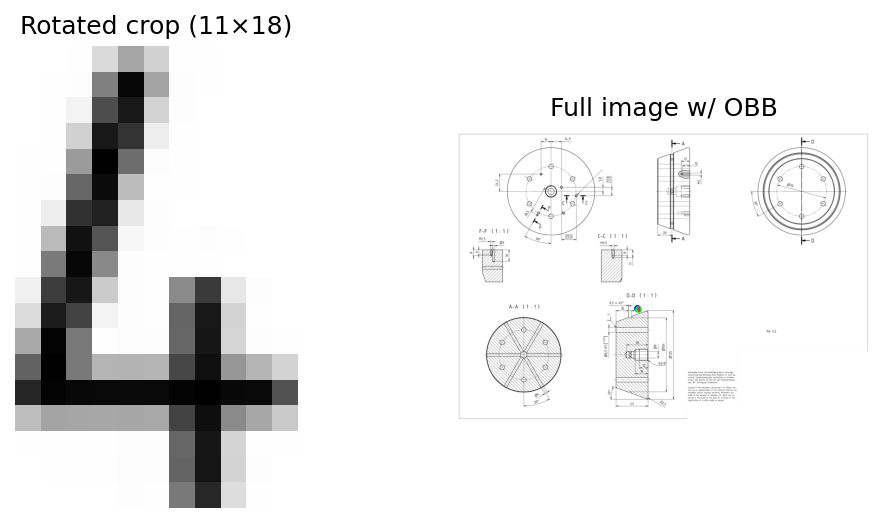

patch[[[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [239 239 239]
  [196 196 196]
  [223 223 223]
  [254 254 254]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [254 254 254]
  [250 250 250]
  [207 207 207]
  [244 244 244]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [254 254 254]
  [242 242 242]
  [ 88  88  88]
  [ 27  27  27]
  [ 39  39  39]
  [202 202 202]
  [253 253 253]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [250 250 250]
  [132 132 132]
  [ 32  32  32]
  [206 206 206]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [255 255 255]
  [254 254 254]
  [254 254 254]
  [164 164 164]
  [ 51  51  51]
  [226 226 226]
  [124 124 124]
  [100 100 100]
  [250 250 250]
  [254 254 254]
  [255 255 255]

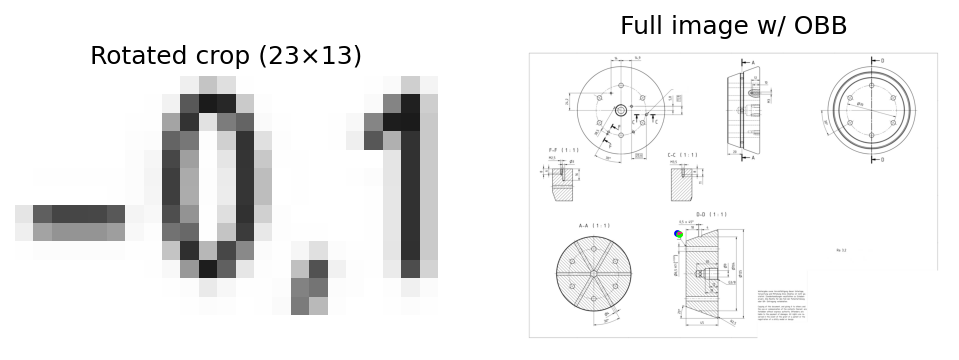

patch[[[255 255 255]
  [254 254 254]
  [244 244 244]
  [201 201 201]
  [174 174 174]
  [183 183 183]
  [225 225 225]
  [252 252 252]
  [254 254 254]
  [248 248 248]
  [223 223 223]
  [182 182 182]
  [174 174 174]
  [173 173 173]
  [185 185 185]
  [229 229 229]
  [253 253 253]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [220 220 220]
  [ 84  84  84]
  [ 15  15  15]
  [  7   7   7]
  [  9   9   9]
  [ 34  34  34]
  [162 162 162]
  [226 226 226]
  [112 112 112]
  [ 27  27  27]
  [  9   9   9]
  [  7   7   7]
  [  7   7   7]
  [ 10  10  10]
  [ 43  43  43]
  [173 173 173]
  [249 249 249]
  [254 254 254]]

 [[225 225 225]
  [ 58  58  58]
  [  3   3   3]
  [ 74  74  74]
  [150 150 150]
  [126 126 126]
  [ 31  31  31]
  [ 12  12  12]
  [ 48  48  48]
  [  3   3   3]
  [ 47  47  47]
  [139 139 139]
  [150 150 150]
  [151 151 151]
  [123 123 123]
  [ 29  29  29]
  [ 17  17  17]
  [168 168 168]
  [254 254 254]]

 [[134 134 134]
  [  1   1   1]
  [ 88  88  88]
  [233 233 233]
  [254 254 25

INFO:__main__:Ann 109: 90.0° → 0.0°


logits tensor([[  3.5065, -15.4964,  -1.7632,  -1.7678]])
idx 0

▶ Ann 109 on img 2 (7443.png)
  orig_rot: 90.0°, pred_rot: 0.0°
  bbox: [1247.575, 908.375, 10.55, 19.55, 90.0]


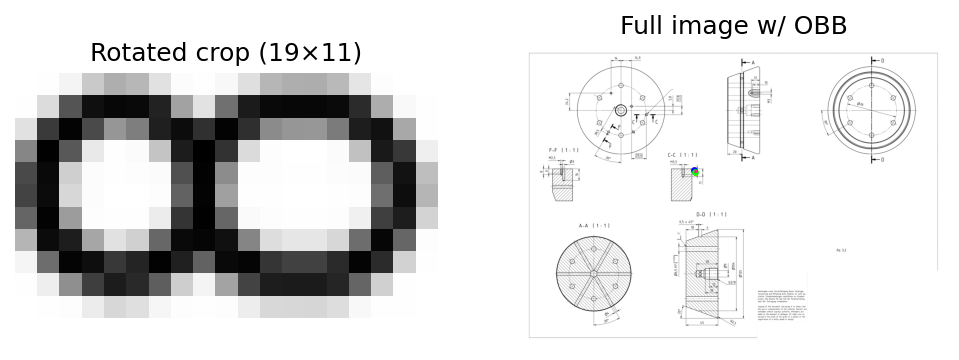

patch[[[228 228 228]
  [ 68  68  68]
  [ 38  38  38]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [ 39  39  39]
  [106 106 106]
  [247 247 247]]

 [[226 226 226]
  [ 41  41  41]
  [  2   2   2]
  [  3   3   3]
  [ 20  20  20]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 22  22  22]
  [ 96  96  96]
  [244 244 244]]

 [[253 253 253]
  [204 204 204]
  [ 43  43  43]
  [  5   5   5]
  [ 94  94  94]
  [224 224 224]
  [231 231 231]
  [232 232 232]
  [232 232 232]
  [232 232 232]
  [232 232 232]
  [232 232 232]
  [232 232 232]
  [232 232 232]
  [232 232 232]
  [232 232 232]
  [232 232 232]
  [231 231 231]
  [243 243 243]
  [255 255 255]]

 [[254 254 254]
  [254 254 25

INFO:__main__:Ann 110: 270.0° → 0.0°


logits tensor([[  6.7206, -20.7137,  -6.4592,   1.8365]])
idx 0

▶ Ann 110 on img 2 (7443.png)
  orig_rot: 270.0°, pred_rot: 0.0°
  bbox: [1288.1499999999999, 988.2, 15.2, 19.5, 270.0]


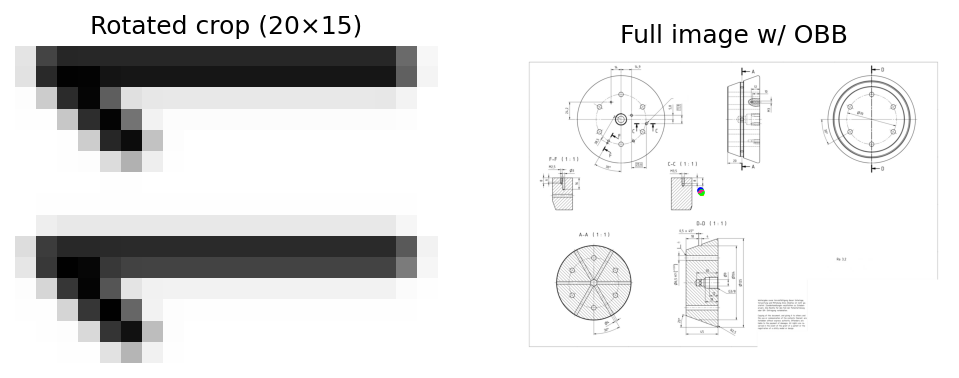

INFO:__main__:Writing COCO to ../data/rotation/batches/rotation_20250721_01/annotations/instances_predicted.json



=== Summary ===
 ann_id  img_id file_name                                                         bbox  orig_rot  pred_rot
     47       2  7443.png                        [2604.715, 105.21, 16.97, 27.78, 0.0]      0.00       0.0
     49       2  7443.png                        [844.645, 791.47, 41.31, 22.46, 0.11]      0.11       0.0
     50       2  7443.png                          [521.1, 1297.26, 217.2, 33.28, 0.0]      0.00       0.0
     51       2  7443.png               [394.65, 928.8000000000001, 19.0, 18.9, 270.0]    270.00       0.0
     52       2  7443.png                  [138.5, 908.4000000000001, 18.6, 10.4, 0.0]      0.00       0.0
     53       2  7443.png   [176.04999999999998, 903.0999999999999, 10.2, 18.1, 270.0]    270.00       0.0
     54       2  7443.png                             [359.75, 835.0, 30.3, 26.4, 0.0]      0.00       0.0
     56       2  7443.png                 [218.04999999999998, 809.3, 44.9, 22.0, 0.0]      0.00       0.0
     57       2  744

In [41]:

# ---------------------------
# MAIN UPDATE
# ---------------------------
def update_rotations(target_image_id: int = 1, debug: bool = False):
    coco_default_4obb = load_coco(COCO_JSON)
    coco_updated_5obb = load_coco(COCO_5OBB)
    #coco_prexcited_4obb = deepcopy(coco_default_4obb)  # will be saved with 4-tuple bbox
    coco_pred_4obb = deepcopy(coco_default_4obb)  # will be saved with updated/predicted 4 -tuple
    model = load_model(CHECKPOINT_PATH)

    images = {img["id"]: img for img in coco_default_4obb["images"]}
    cache = {}
    records = []

    for ann, ann_pred, in zip(coco_updated_5obb["annotations"],
                                       coco_pred_4obb["annotations"],):
        if ann["image_id"] != target_image_id:
            continue

        # Convert all to 5-tuple: [cx, cy, w, h, rotation]
        cx, cy, w, h, orig_rot = ann["bbox"]

        # Only correct if rotation is within ±3° of base classes
        if not any(abs(orig_rot - base) <= 3 for base in CLASS_NAMES):
            continue

        info = images[ann["image_id"]]
        fname = info["file_name"]
        if fname not in cache:
            img = cv2.imread(str(IMAGES_DIR / fname))
            if img is None:
                logger.error(f"Cannot load {fname}")
                continue
            cache[fname] = img
        full_img = cache[fname]

        patch, (x1, y1, x2, y2) = crop_rotated_preserve(full_img, cx, cy, w, h, orig_rot)

        print(f"patch{patch}")
                 
        pred_rot = predict_angle(model, patch)

        records.append({
            "ann_id": ann["id"],
            "img_id": ann["image_id"],
            "file_name": fname,
            "bbox": [cx, cy, w, h, orig_rot],
            "orig_rot": orig_rot,
            "pred_rot": pred_rot
        })

        # Update ann_pred (saved as COCO)
        ann_pred["bbox"] = [cx, cy, w, h, orig_rot]  # 4-tuple format
        if pred_rot != orig_rot:
            logger.info(f"Ann {ann['id']}: {orig_rot}° → {pred_rot}°")
            ann_pred.setdefault("attributes", {})["rotation"] = pred_rot

        if debug:
            debug_annotation(ann["id"], ann["image_id"],
                             fname, orig_rot, pred_rot,
                             [cx, cy, w, h, orig_rot], full_img, aabb_coords=(x1, y1, x2, y2), patch=patch)

    # Save outputs
    save_coco(ann_pred, PRED_JSON)

    df = pd.DataFrame(records)
    df.to_csv(path_or_buf="./results.csv")
    print("\n=== Summary ===")
    print(df.to_string(index=False))


if __name__ == "__main__":
    update_rotations(target_image_id=2, debug=True)


In [12]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from pathlib import Path
import pandas as pd

def show_image_with_annotations_from_coco(coco_json_path: Path,
                                          images_dir: Path,
                                          image_filename: str,
                                          show_centres: bool = True,
                                          centre_color: str = "lime") -> None:
    """
    Display one COCO image with all rotated bounding boxes from a COCO-style JSON.
    """

    # Load COCO data
    with open(coco_json_path, "r", encoding="utf-8") as f:
        coco = json.load(f)

    print(coco.keys())
    # Get image_id from image filename
    image_entry = next((img for img in coco["images"] if img["file_name"] == image_filename), None)
    if not image_entry:
        print(f"Image {image_filename} not found in COCO JSON.")
        return

    image_id = image_entry["id"]
    img_path = images_dir / image_filename

    if not img_path.exists():
        print("Image not found on disk:", img_path)
        return

    # Load image
    img = plt.imread(img_path)
    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
    ax.imshow(img, aspect="equal")
    ax.set_title(f'{image_filename} (image_id={image_id})')
    ax.axis("off")

    # Get annotations for this image
    annotations = [ann for ann in coco["annotations"] if ann["image_id"] == image_id]

    if not annotations:
        print(f"No annotations found for image_id={image_id}")
        return

    for ann in annotations:
        x, y, w, h = ann["bbox"][:4]
        
        # Get rotation
        if len(ann["bbox"]) == 5:
            rotation = ann["bbox"][4]
        else:
            rotation = ann.get("attributes", {}).get("rotation", 0.0)

        # Draw rotated rectangle
        cx, cy = x + w / 2, y + h / 2
        rect = Rectangle((cx - w / 2, cy - h / 2), w, h,
                         linewidth=0.3, edgecolor="red", fill=False)
        transf = Affine2D().rotate_deg_around(cx, cy, rotation) + ax.transData
        rect.set_transform(transf)
        ax.add_patch(rect)
        ax.text(cx, cy, f'{rotation:.1f}°', color='green', fontsize=8, ha='right', va='top')

        if show_centres:
            ax.scatter(cx, cy, color=centre_color, s=1, zorder=1)

    plt.show()


In [13]:
show_image_with_annotations_from_coco(
    coco_json_path=Path("../data/rotation/batches/rotation_20250721_01/instances_predicted.json"),
    images_dir=Path("../data/rotation/batches/rotation_20250721_01/images/default"),
    image_filename="7443.png"
)


dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes'])


KeyError: 'images'

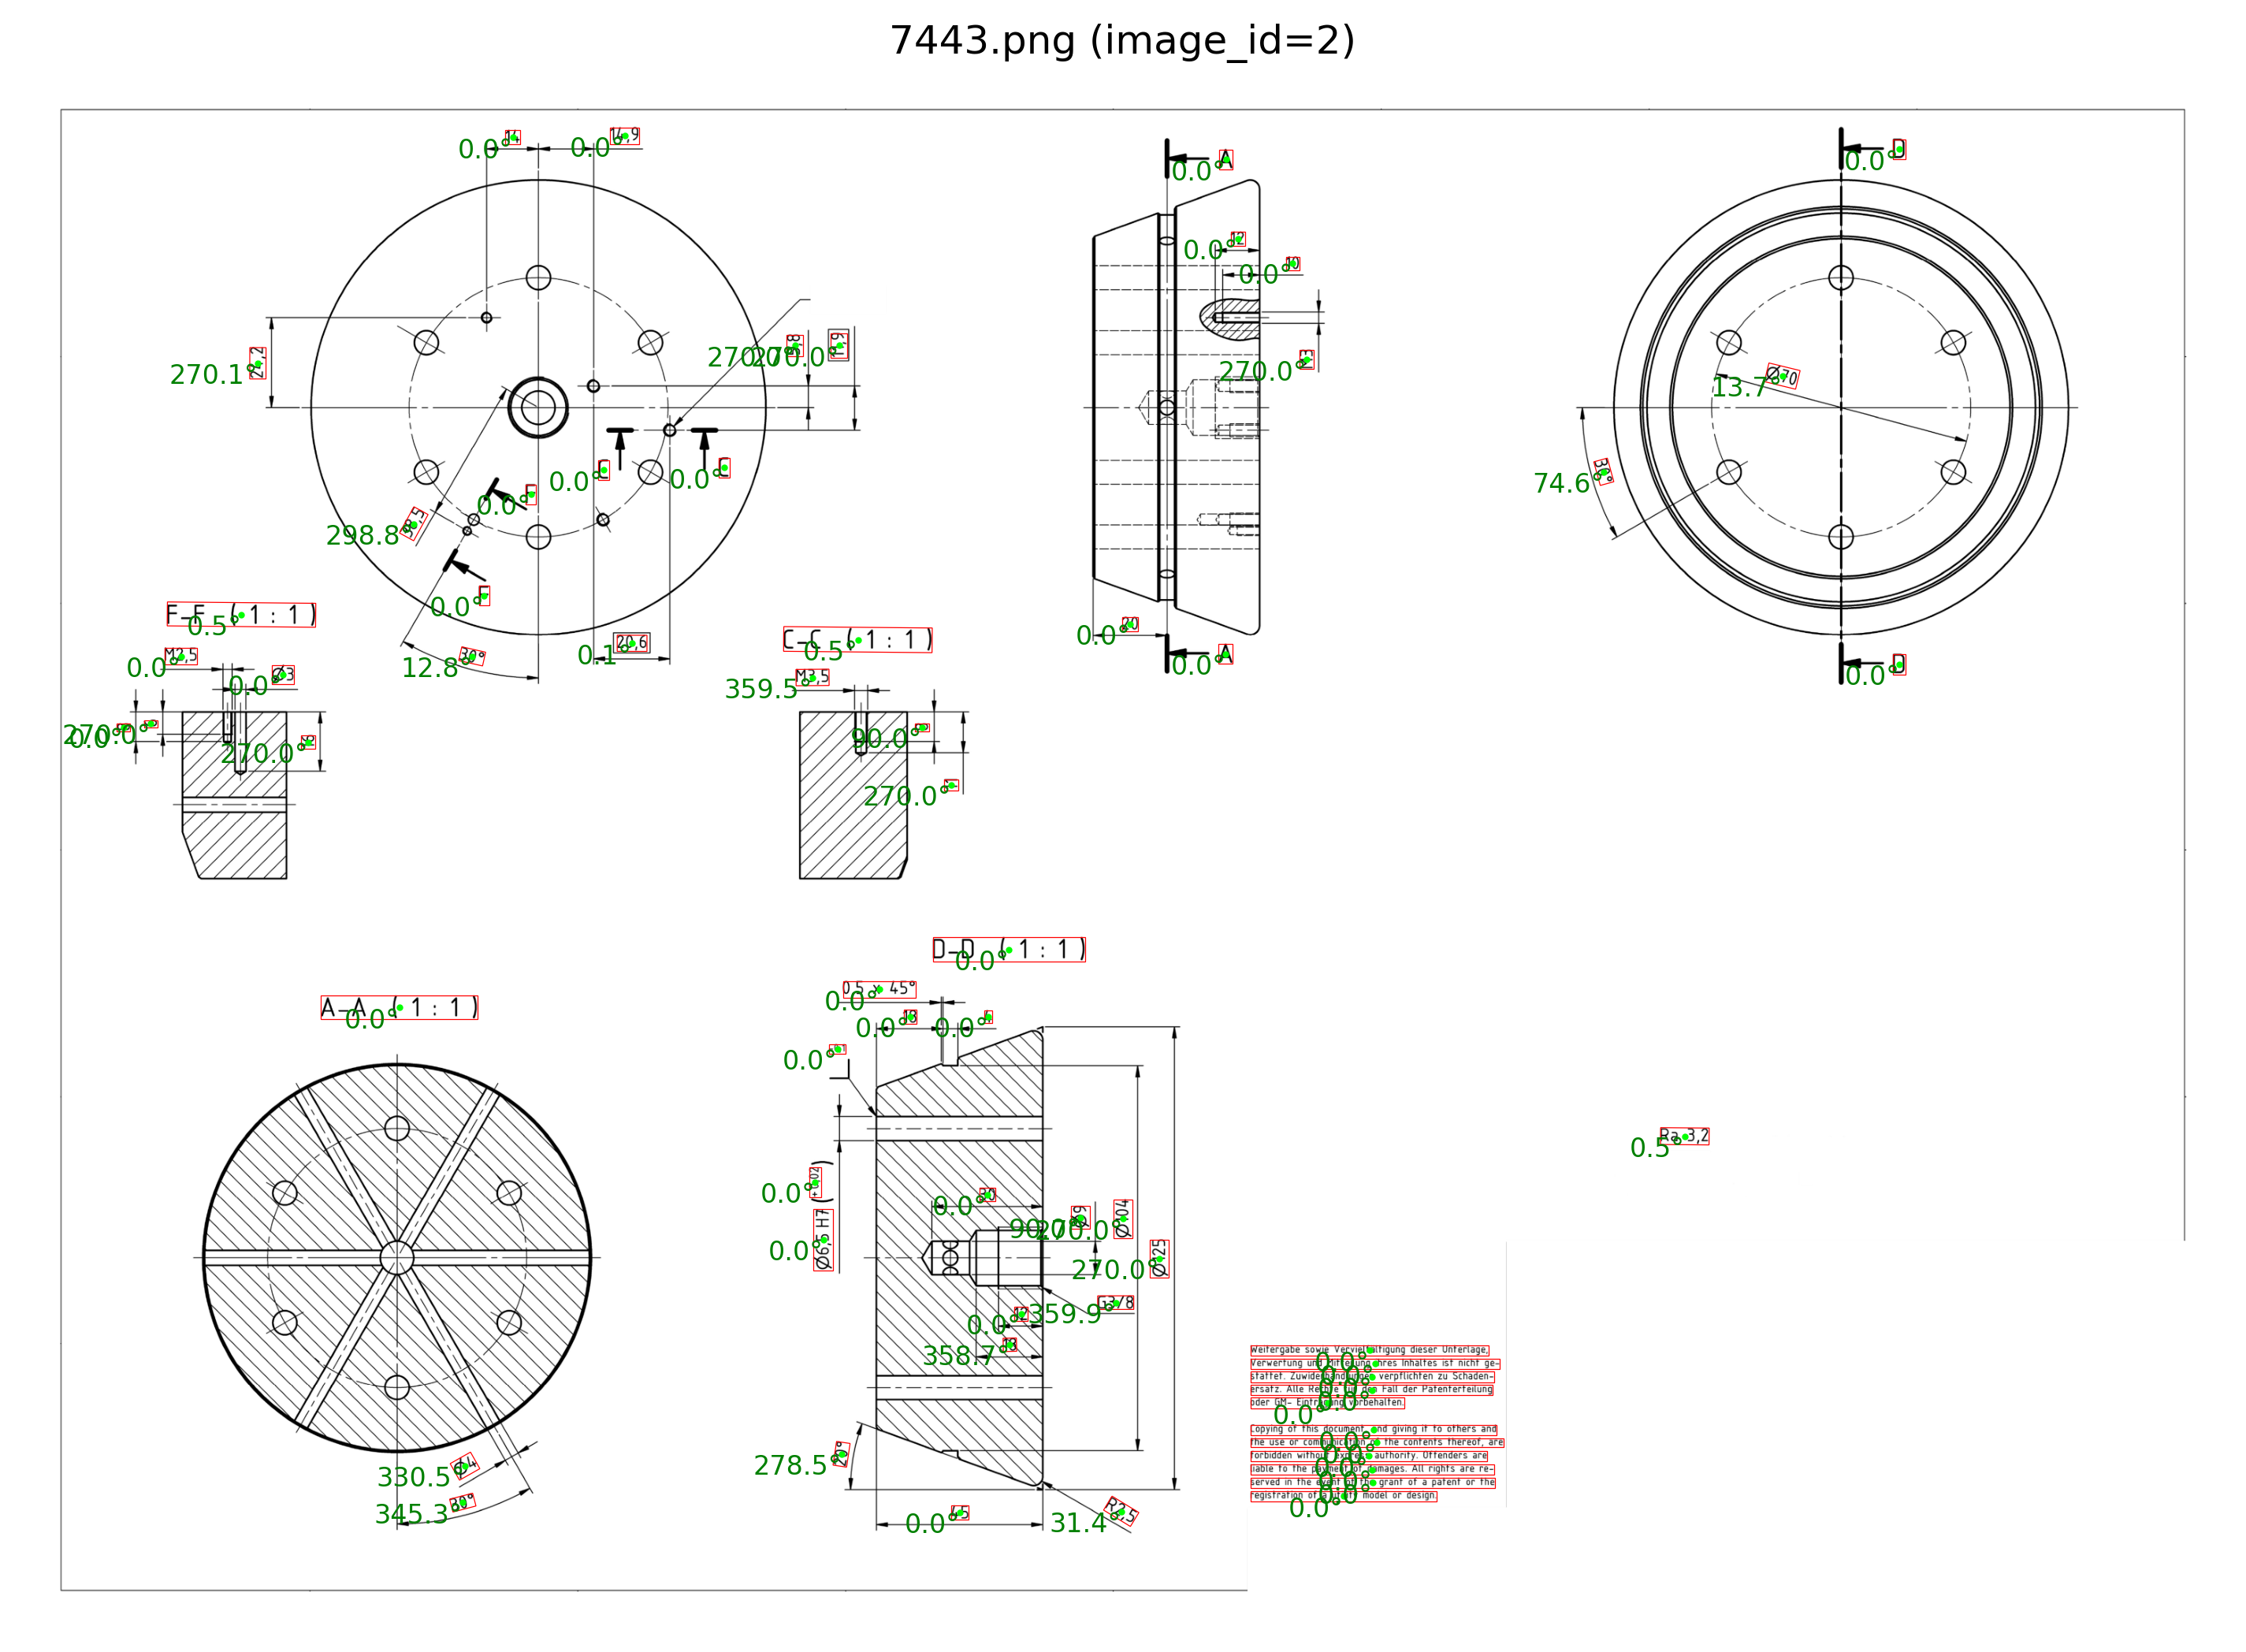

In [30]:
show_image_with_annotations_from_coco(
    coco_json_path=Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json"),
    images_dir=Path("../data/rotation/batches/rotation_20250721_01/images/default"),
    image_filename="7443.png"
)
